# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from helper_functions import scree_plot, get_best_n_comp
from sklearn.preprocessing import OneHotEncoder

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [231]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('AZDIAS: ', azdias.shape)
print('Feature Summary: ', feat_info.shape)

azdias.head(30)

AZDIAS:  (891221, 85)
Feature Summary:  (85, 4)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         -1                     2          1            2.0   
1         -1                     1          2            5.0   
2         -1                     3          2            3.0   
3          2                     4          2            2.0   
4         -1                     3          1            5.0   
5          3                     1          2            2.0   
6         -1                     2          2            5.0   
7         -1                     1          1            3.0   
8         -1                     3          1            3.0   
9         -1                     3          2            4.0   
10         0                     3          2            1.0   
11        -1                     2          1            6.0   
12        -1                     3          1            6.0   
13        -1                     1          2            5.0   
14        -1                     3          1            6.0   
15         1                     4          2            4.0   
16        -1                     1          2            1.0   
17        -1                     2          1            6.0   
18        -1                     2          2            6.0   
19        -1                     3          1            3.0   
20        -1                     2          2            4.0   
21        -1                     2          1            3.0   
22        -1                     1          1            4.0   
23        -1                     3          1            3.0   
24        -1                     3          2            6.0   
25        -1                     1          1            3.0   
26        -1                     3          1            3.0   
27        -1                     3          1            4.0   
28        -1                     3          1            2.0   
29         2                     4          2            1.0   

    FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   3              4                 3               5   
1                   1              5                 2               5   
2                   1              4                 1               2   
3                   4              2                 5               2   
4                   4              3                 4               1   
5                   3              1                 5               2   
6                   1              5                 1               5   
7                   3              3                 4               1   
8                   4              4                 2               4   
9                   2              4                 2               3   
10                  2              2                 5               3   
11                  3              4                 3               5   
12                  5              3                 4               2   
13                  1              4                 3               5   
14                  3              4                 3               5   
15                  4              1                 5               1   
16                  4              3                 1               4   
17                  3              4                 3               5   
18                  2              4                 1               5   
19                  5              2                 3               1   
20                  4              3                 1               4   
21                  3              4                 1               2   
22                  1              5                 3               5   
23                  5              3                 3               2   
24                  3              4                 3               5   
25                  3              5                 3               5   
26                  5

In [4]:
azdias.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...          PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...       774706.000000   
mean                2.874167          3.075121      ...            2.253330   
std                 1.486731          1.353248      ...            0.972008   
min                 1.000000          1.000000      ...            0.000000   
25%                 2.000000          2.000000      ...            1.000000   
50%                 3.000000          3.000000      ...            2.000000   
75%                 4.000000          4.000000      ...            3.000000   
max                 5.000000          5.000000      ...            4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

In [5]:
feat_info.head(10)

attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
5          FINANZ_SPARER            person      ordinal               [-1]
6       FINANZ_VORSORGER            person      ordinal               [-1]
7         FINANZ_ANLEGER            person      ordinal               [-1]
8  FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9       FINANZ_HAUSBAUER            person      ordinal               [-1]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [232]:
# Before Preprocessing
azdias_null = azdias.isnull().sum()[azdias.isnull().sum() != 0]
df_azdias_null = pd.DataFrame({'Count': azdias_null, '%': azdias_null/azdias.shape[0]*100})

df_azdias_null.sort_values(by='Count', ascending=False, inplace=True)
df_azdias_null

Count          %
KK_KUNDENTYP         584612  65.596749
KBA05_BAUMAX         133324  14.959701
KBA05_ANTG4          133324  14.959701
KBA05_ANTG1          133324  14.959701
KBA05_ANTG2          133324  14.959701
KBA05_GBZ            133324  14.959701
MOBI_REGIO           133324  14.959701
KBA05_ANTG3          133324  14.959701
KKK                  121196  13.598872
REGIOTYP             121196  13.598872
PLZ8_ANTG1           116515  13.073637
PLZ8_ANTG3           116515  13.073637
PLZ8_ANTG4           116515  13.073637
PLZ8_BAUMAX          116515  13.073637
PLZ8_HHZ             116515  13.073637
PLZ8_GBZ             116515  13.073637
PLZ8_ANTG2           116515  13.073637
W_KEIT_KIND_HH       107602  12.073549
KBA13_ANZAHL_PKW     105800  11.871354
CAMEO_DEU_2015        98979  11.106000
CAMEO_DEUG_2015       98979  11.106000
CAMEO_INTL_2015       98979  11.106000
ARBEIT                97216  10.908181
ORTSGR_KLS9           97216  10.908181
RELAT_AB              97216  10.908181
ANZ_HH_TITEL          97008  10.884842
BALLRAUM              93740  10.518154
EWDICHTE              93740  10.518154
INNENSTADT            93740  10.518154
GEBAEUDETYP_RASTER    93155  10.452514
WOHNLAGE              93148  10.451729
OST_WEST_KZ           93148  10.451729
MIN_GEBAEUDEJAHR      93148  10.451729
GEBAEUDETYP           93148  10.451729
ANZ_HAUSHALTE_AKTIV   93148  10.451729
KONSUMNAEHE           73969   8.299737
ANZ_PERSONEN          73499   8.247000
SOHO_KZ               73499   8.247000
TITEL_KZ              73499   8.247000
ALTER_HH              73499   8.247000
ANZ_TITEL             73499   8.247000
WOHNDAUER_2008        73499   8.247000
HH_EINKOMMEN_SCORE    18348   2.058749
ONLINE_AFFINITAET      4854   0.544646
GFK_URLAUBERTYP        4854   0.544646
RETOURTYP_BK_S         4854   0.544646
LP_STATUS_GROB         4854   0.544646
LP_STATUS_FEIN         4854   0.544646
LP_FAMILIE_GROB        4854   0.544646
LP_FAMILIE_FEIN        4854   0.544646
LP_LEBENSPHASE_GROB    4854   0.544646
LP_LEBENSPHASE_FEIN    4854   0.544646
CJT_GESAMTTYP          4854   0.544646

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
np_array = feat_info['missing_or_unknown'].str.replace('[','').str.replace(']','').str.split(',').values
df_mou_list = pd.DataFrame({'missing_or_unknown': np_array}, index=feat_info['attribute'].values)

def convert_missing_vals():    
    for index, row in df_mou_list.iterrows():
        if not ('' in row[0] or 'X' in row[0] or 'XX' in row[0]):
            row[0] = [int(row[0][i]) for i in range(0, len(row[0]))]
    
        # Preprocess azdias demographics data
        for column in azdias.columns:
            azdias[column] = azdias[column].replace(df_mou_list.loc[column][0], np.nan)
    
convert_missing_vals()



In [8]:
# Check that column values that matches a 'missing' or 'unknown' value code are converted to NaN
azdias.head(10)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   
5       3.0                   1.0          2            2.0   
6       NaN                   2.0          2            5.0   
7       NaN                   1.0          1            3.0   
8       NaN                   3.0          1            3.0   
9       NaN                   3.0          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   
5                  3              1                 5               2   
6                  1              5                 1               5   
7                  3              3                 4               1   
8                  4              4                 2               4   
9                  2              4                 2               3   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   
5                      2                 5    ...            2.0         3.0   
6                      4                 3    ...            3.0         3.0   
7                      3                 2    ...            3.0         3.0   
8                      2                 2    ...            2.0         3.0   
9                      5                 4    ...            2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   
5         1.0         1.0          1.0       5.0       5.0     2.0   
6         1.0         0.0          1.0       5.0       5.0     4.0   
7         1.0         0.0          1.0       4.0       4.0     2.0   
8         2.0         1.0          1.0       3.0       3.0     2.0   
9         2.0         1.0          1.0       3.0       3.0     2.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  
5          3.0       3.0  
6          6.0       3.0  
7          5.0       2.0  
8          4.0       3.0  
9          3.0       1.0  

[10 rows x 85 columns]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [226]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Missing data count and % after preprocessing
azdias_null = azdias.isnull().sum()[azdias.isnull().sum() != 0]
df_azdias_null = pd.DataFrame({'Count': azdias_null, '%': azdias_null/azdias.shape[0]*100})

df_azdias_null.sort_values(by='Count', ascending=False, inplace=True)
df_azdias_null


Count          %
ALTERSKATEGORIE_GROB     2881   0.323264
RETOURTYP_BK_S           4854   0.544646
LP_STATUS_GROB           4854   0.544646
ONLINE_AFFINITAET        4854   0.544646
GFK_URLAUBERTYP          4854   0.544646
CJT_GESAMTTYP            4854   0.544646
LP_STATUS_FEIN           4854   0.544646
HH_EINKOMMEN_SCORE      18348   2.058749
SOHO_KZ                 73499   8.247000
ANZ_PERSONEN            73499   8.247000
ANZ_TITEL               73499   8.247000
WOHNDAUER_2008          73499   8.247000
KONSUMNAEHE             73969   8.299737
LP_FAMILIE_FEIN         77792   8.728699
LP_FAMILIE_GROB         77792   8.728699
WOHNLAGE                93148  10.451729
OST_WEST_KZ             93148  10.451729
MIN_GEBAEUDEJAHR        93148  10.451729
GEBAEUDETYP             93148  10.451729
GEBAEUDETYP_RASTER      93155  10.452514
EWDICHTE                93740  10.518154
BALLRAUM                93740  10.518154
INNENSTADT              93740  10.518154
LP_LEBENSPHASE_GROB     94572  10.611509
ANZ_HH_TITEL            97008  10.884842
ORTSGR_KLS9             97274  10.914689
RELAT_AB                97375  10.926022
ARBEIT                  97375  10.926022
LP_LEBENSPHASE_FEIN     97632  10.954859
CAMEO_DEU_2015          99352  11.147852
...                       ...        ...
CAMEO_INTL_2015         99352  11.147852
ANZ_HAUSHALTE_AKTIV     99611  11.176913
KBA13_ANZAHL_PKW       105800  11.871354
PRAEGENDE_JUGENDJAHRE  108164  12.136608
NATIONALITAET_KZ       108315  12.153551
HEALTH_TYP             111196  12.476816
SHOPPER_TYP            111196  12.476816
VERS_TYP               111196  12.476816
PLZ8_ANTG2             116515  13.073637
PLZ8_ANTG1             116515  13.073637
PLZ8_ANTG3             116515  13.073637
PLZ8_HHZ               116515  13.073637
PLZ8_BAUMAX            116515  13.073637
PLZ8_GBZ               116515  13.073637
PLZ8_ANTG4             116515  13.073637
KBA05_ANTG3            133324  14.959701
KBA05_ANTG1            133324  14.959701
MOBI_REGIO             133324  14.959701
KBA05_GBZ              133324  14.959701
KBA05_ANTG4            133324  14.959701
KBA05_ANTG2            133324  14.959701
W_KEIT_KIND_HH         147988  16.605084
REGIOTYP               158064  17.735668
KKK                    158064  17.735668
ALTER_HH               310267  34.813699
GEBURTSJAHR            392318  44.020282
KBA05_BAUMAX           476524  53.468668
KK_KUNDENTYP           584612  65.596749
AGER_TYP               685843  76.955435
TITEL_KZ               889061  99.757636

[61 rows x 2 columns]

In [10]:
# Investigate patterns in the amount of missing data in each column.
df_azdias_null.describe()

Count          %
count      61.000000  61.000000
mean   137277.524590  15.403309
std    157099.496443  17.627446
min      2881.000000   0.323264
25%     93148.000000  10.451729
50%     99352.000000  11.147852
75%    116515.000000  13.073637
max    889061.000000  99.757636

(61, 2)


TITEL_KZ                  True
AGER_TYP                  True
KK_KUNDENTYP              True
KBA05_BAUMAX              True
GEBURTSJAHR               True
ALTER_HH                  True
KKK                       True
REGIOTYP                  True
W_KEIT_KIND_HH           False
KBA05_ANTG3              False
KBA05_ANTG1              False
KBA05_ANTG2              False
KBA05_GBZ                False
KBA05_ANTG4              False
MOBI_REGIO               False
PLZ8_ANTG2               False
PLZ8_ANTG1               False
PLZ8_ANTG3               False
PLZ8_ANTG4               False
PLZ8_BAUMAX              False
PLZ8_HHZ                 False
PLZ8_GBZ                 False
VERS_TYP                 False
SHOPPER_TYP              False
HEALTH_TYP               False
NATIONALITAET_KZ         False
PRAEGENDE_JUGENDJAHRE    False
KBA13_ANZAHL_PKW         False
ANZ_HAUSHALTE_AKTIV      False
CAMEO_INTL_2015          False
                         ...  
CAMEO_DEU_2015           False
LP_LEBEN

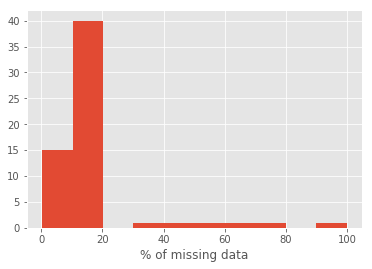

In [11]:
print(df_azdias_null.shape)
plt.style.use('ggplot')
plt.xlabel('% of missing data')
plt.hist(df_azdias_null['%'])

df_azdias_null['%'] >= df_azdias_null['%'].std()

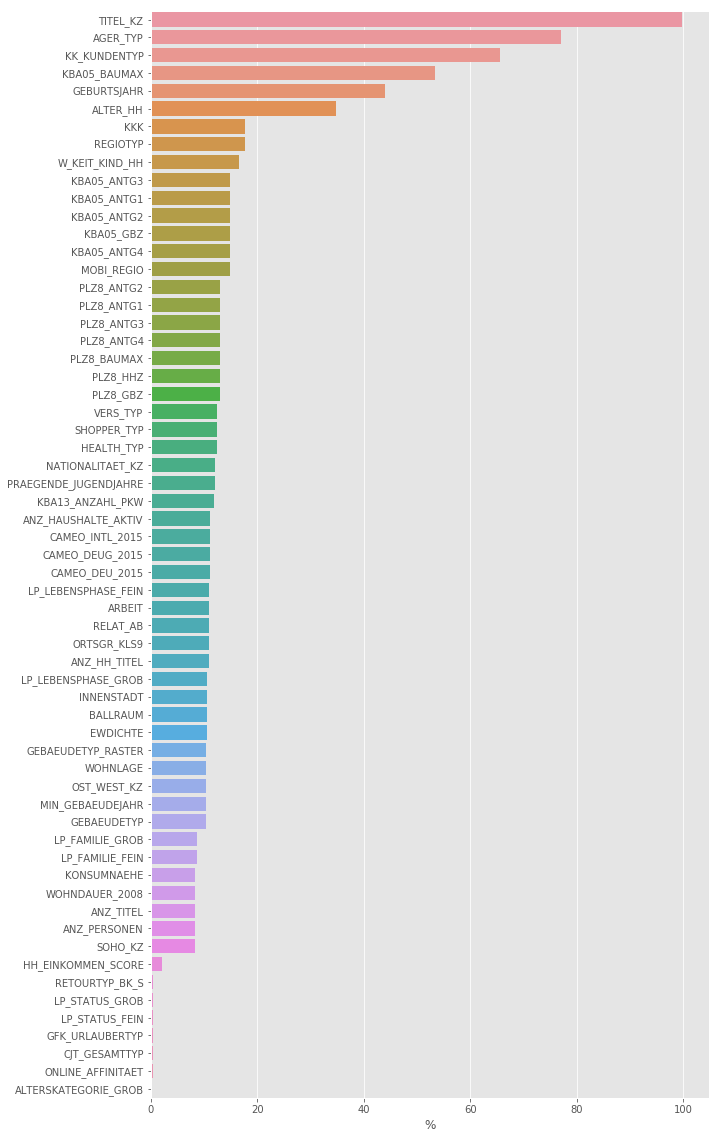

In [12]:
plt.figure(figsize=(10, 20))
sns.barplot(x=df_azdias_null['%'], y=df_azdias_null.index, data=df_azdias_null)


In [13]:
outliers = df_azdias_null['%'][df_azdias_null['%'] > df_azdias_null['%'].std()]
outliers

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
KKK             17.735668
REGIOTYP        17.735668
Name: %, dtype: float64

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliers = df_azdias_null['%'][df_azdias_null['%'] > 18]
azdias.drop(outliers.index, axis=1, inplace=True)
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Before preprocessing demographics data for the general population of Germany (azdias), 'KK_KUNDENTYP' seemed to be the only outlier which had 584612 counts of missing data (65.6% of the azdias dataset).

However, after preprocessing the dataset, the following columns turned out to be above the standard deviation:
- TITEL_KZ        99.757636 %
- AGER_TYP        76.955435 %
- KK_KUNDENTYP    65.596749 %
- KBA05_BAUMAX    53.468668 %
- GEBURTSJAHR     44.020282 %
- ALTER_HH        34.813699 %
- KKK             17.735668 %
- REGIOTYP        17.735668 %

However, based on the bar plot, the % of missing data in 'KKK' and 'REGIOTYP' columns didn't seem to be outliers.
So, I've decided to drop only the top 6 columns from the columns listed above.

The number of columns has now changed from 85 to 79.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?
azdias_null_row = azdias.isnull().sum(axis=1)
# azdias_null_row.describe()

df_azdias_null_row = pd.DataFrame({'Count': azdias_null_row, '%': round(azdias_null_row/azdias.shape[1]*100, 2)})
df_azdias_null_row.sort_values(by='Count', ascending=False, inplace=True)
df_azdias_null_row

Count      %
732775     49  62.03
643174     49  62.03
472919     48  60.76
345274     47  59.49
299868     47  59.49
582092     47  59.49
681255     47  59.49
818343     47  59.49
582109     47  59.49
439981     47  59.49
439979     47  59.49
299814     47  59.49
38748      47  59.49
299838     47  59.49
681206     47  59.49
299769     47  59.49
681204     47  59.49
439958     47  59.49
863655     47  59.49
863654     47  59.49
681203     47  59.49
681202     47  59.49
863651     47  59.49
582139     47  59.49
38761      47  59.49
38763      47  59.49
681273     47  59.49
818316     47  59.49
103633     47  59.49
582069     47  59.49
...       ...    ...
349076      0   0.00
349078      0   0.00
349079      0   0.00
349081      0   0.00
349083      0   0.00
349084      0   0.00
349085      0   0.00
349054      0   0.00
349052      0   0.00
349028      0   0.00
349037      0   0.00
349029      0   0.00
349030      0   0.00
349031      0   0.00
349032      0   0.00
349033      0   0.00
349034      0   0.00
349035      0   0.00
349036      0   0.00
349041      0   0.00
349051      0   0.00
349043      0   0.00
349044      0   0.00
349045      0   0.00
349046      0   0.00
349047      0   0.00
349048      0   0.00
349049      0   0.00
349050      0   0.00
891220      0   0.00

[891221 rows x 2 columns]

(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0.   ,   6.203,  12.406,  18.609,  24.812,  31.015,  37.218,
         43.421,  49.624,  55.827,  62.03 ]),
 <a list of 10 Patch objects>)

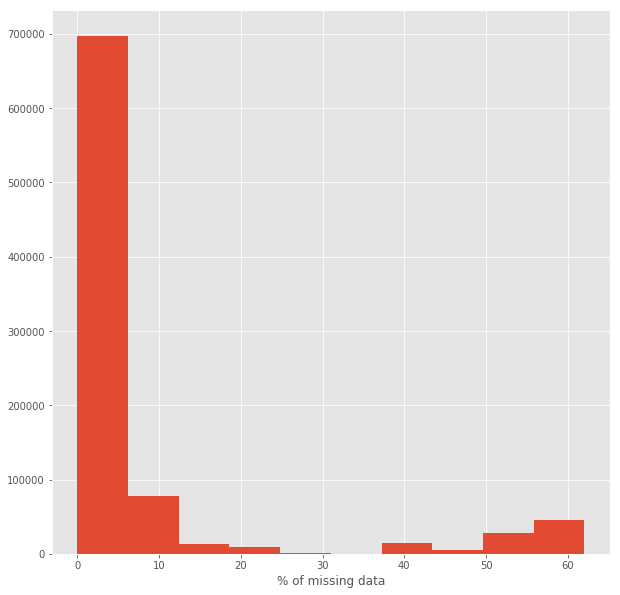

In [16]:
plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlabel('% of missing data')
plt.hist(df_azdias_null_row['%'])

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
row_above_threshold = df_azdias_null_row[df_azdias_null_row['Count'] >= 32]
row_below_threshold = df_azdias_null_row[df_azdias_null_row['Count'] < 32]

print(row_above_threshold) # many missing values
print(row_below_threshold) # few missing values

        Count      %
732775     49  62.03
643174     49  62.03
472919     48  60.76
345274     47  59.49
299868     47  59.49
582092     47  59.49
681255     47  59.49
818343     47  59.49
582109     47  59.49
439981     47  59.49
439979     47  59.49
299814     47  59.49
38748      47  59.49
299838     47  59.49
681206     47  59.49
299769     47  59.49
681204     47  59.49
439958     47  59.49
863655     47  59.49
863654     47  59.49
681203     47  59.49
681202     47  59.49
863651     47  59.49
582139     47  59.49
38761      47  59.49
38763      47  59.49
681273     47  59.49
818316     47  59.49
103633     47  59.49
582069     47  59.49
...       ...    ...
416126     32  40.51
834523     32  40.51
784732     32  40.51
547076     32  40.51
276425     32  40.51
59749      32  40.51
754134     32  40.51
547216     32  40.51
685818     32  40.51
197894     32  40.51
248811     32  40.51
656180     32  40.51
32154      32  40.51
6261       32  40.51
40507      32  40.51
296346     32

                      Count         %
ALTERSKATEGORIE_GROB   2881  0.323264
RETOURTYP_BK_S         4854  0.544646
LP_STATUS_GROB         4854  0.544646
ONLINE_AFFINITAET      4854  0.544646
GFK_URLAUBERTYP        4854  0.544646


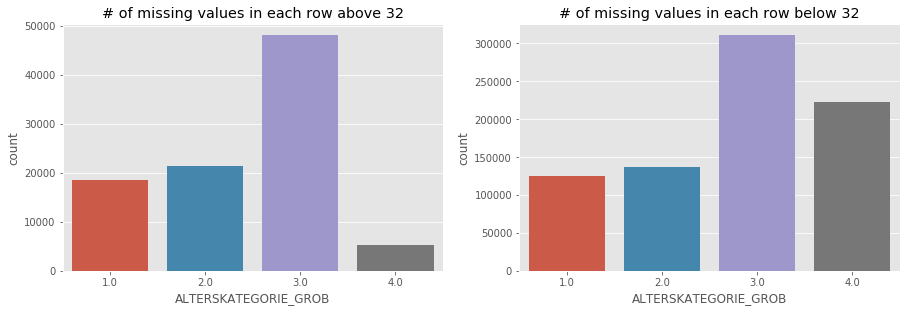

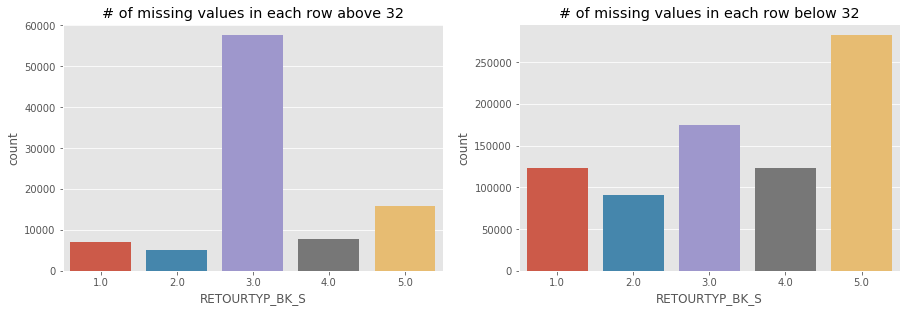

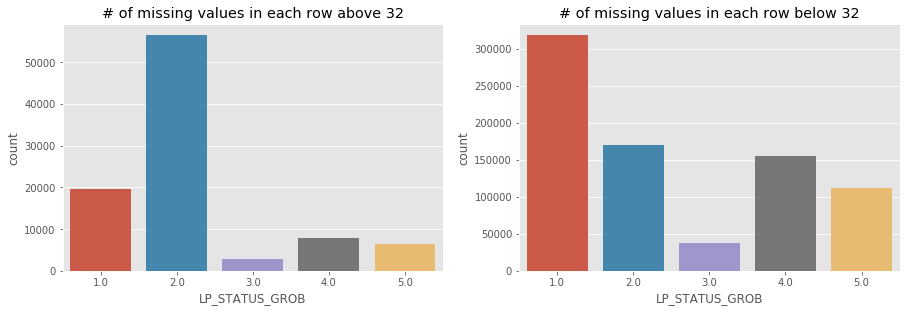

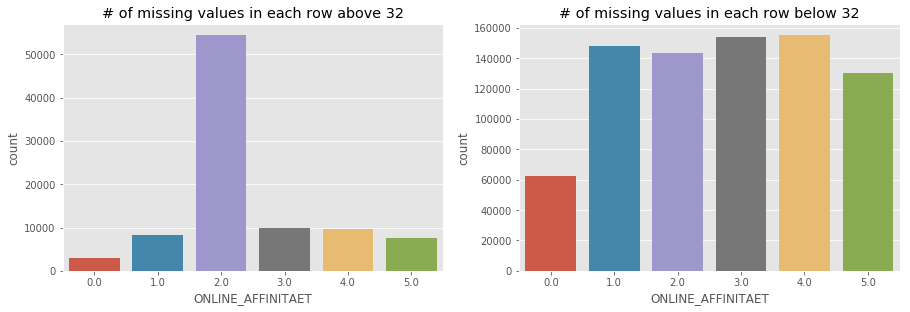

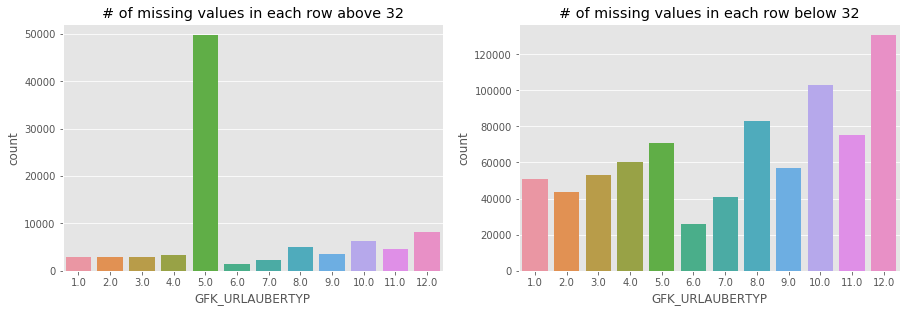

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

df_azdias_null.sort_values(by='Count', inplace=True)
top_k = df_azdias_null[df_azdias_null['%'] < 18][:5]
top_k.index
print(top_k)


def compare_plots(column):
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax1.set_title('# of missing values in each row above 32')
    ax2.set_title('# of missing values in each row below 32')
    
    sns.countplot(azdias.loc[row_above_threshold.index, column], ax=ax1)
    sns.countplot(azdias.loc[row_below_threshold.index, column], ax=ax2)

for i in range(top_k.shape[0]):
    compare_plots(top_k.index[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

An analysis on the missing values in each row in the following columns has been conducted:

- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- RETOURTYP_BK_S: Return type (types of shopping return behaviours?)
- LP_STATUS_GROB: Social status, rough scale
- ONLINE_AFFINITAET: Online affinity
- GFK_URLAUBERTYP: Vacation habits

First, the dataset was divided into two subsets based on the number of missing values in each row, 1) one that is equal or above 32, and 2) the other below 32.

Then, the distribution of data values on the 5 columns listed above that are not missing data (or are missing very little data) was visualised.

The distribution patterns on all of the columns between the data with many missing values and the data with few or no missing values are qualitatively different, which suggest that they should not be dropped.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since **the unsupervised learning techniques to be used will only work on data that is encoded numerically**, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# Create a dataset with the subset with few or no missing values.
azdias = azdias[azdias.isnull().sum(axis=1) < 32]
azdias.reset_index(inplace=True, drop=True)
azdias.isnull().sum(axis=1).sum()

1014460

In [20]:
# How many features are there of each data type?
feat_info.head()
# feat_info[feat_info['type'] == 'interval']

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [21]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# drop features that were dropped in the demographics data
for i in range(len(outliers.index)):
    feat_info.drop(feat_info.index[feat_info['attribute'] == outliers.index[i]].tolist(), inplace=True)

feat_info

attribute information_level         type missing_or_unknown
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
30              SEMIO_ERL            person      ordinal             [-1,9]
31             SEMIO_KULT            person      ordinal             [-1,9]
..                    ...               ...          ...                ...
54       MIN_GEBAEUDEJAHR          building      numeric                [0]
55            OST_WEST_KZ          building  categorical               [-1]
56               WOHNLAGE          building        mixed               [-1]
57        CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58         CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
59        CAMEO_INTL_2015     microcell_rr4        mixed            [-1,XX]
60            KBA05_ANTG1     microcell_rr3      ordinal               [-1]
61            KBA05_ANTG2     microcell_rr3      ordinal               [-1]
62            KBA05_ANTG3     microcell_rr3      ordinal               [-1]
63            KBA05_ANTG4     microcell_rr3      ordinal               [-1]
65              KBA05_GBZ     microcell_rr3      ordinal             [-1,0]
66               BALLRAUM          postcode      ordinal               [-1]
67               EWDICHTE          postcode      ordinal               [-1]
68             INNENSTADT          postcode      ordinal               [-1]
69     GEBAEUDETYP_RASTER        region_rr1      ordinal                 []
70                    KKK        region_rr1      ordinal             [-1,0]
71             MOBI_REGIO        region_rr1      ordinal                 []
72      ONLINE_AFFINITAET        region_rr1      ordinal                 []
73               REGIOTYP        region_rr1      ordinal             [-1,0]
74       KBA13_ANZAHL_PKW    macrocell_plz8      numeric                 []
75             PLZ8_ANTG1    macrocell_plz8      ordinal        

In [23]:
cat_variables = feat_info[feat_info['type'] == 'categorical']
cat_variables

attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical               [-1]
42          ZABEOTYP            person  categorical             [-1,9]
52       GEBAEUDETYP          building  categorical             [-1,0]
55       OST_WEST_KZ          building  categorical               [-1]
57   CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58    CAMEO_DEU_2015     microcell_rr4  categorical               [XX]

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_binary = []
cat_multi = []

# print(cat_variables.shape)

for cat in cat_variables['attribute']:
    if azdias[cat].nunique() > 2:
        cat_multi.append(cat)
    else:
        cat_binary.append(cat)

print('binary categorical variables: ', cat_binary)
print('multi-level categorical variables: ', cat_multi)

binary categorical variables:  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
multi-level categorical variables:  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.
'''
OST_WEST_KZ is the one that takes on non-numeric values, 'O' and 'W'.
'''
azdias['OST_WEST_KZ'].replace(['O', 'W'], [0, 1], inplace=True)
azdias['OST_WEST_KZ'].head()

0    1
1    1
2    1
3    1
4    1
Name: OST_WEST_KZ, dtype: int64

In [26]:
'''
For multi-level categoricals, encode the values
using multiple dummy variables (e.g. via OneHotEncoder).
'''
# Didn't work..
# df_cat_multi = pd.DataFrame(cat_multi)
# enc = OneHotEncoder(categories=df_cat_multi, handle_unknown='ignore', sparse=False)
# enc.fit_transform(df_cat_multi)

azdias = pd.get_dummies(azdias, columns=cat_multi)

In [27]:
azdias

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        1.0          2                  1              5   
1                        3.0          2                  1              4   
2                        4.0          2                  4              2   
3                        3.0          1                  4              3   
4                        1.0          2                  3              1   
5                        2.0          2                  1              5   
6                        1.0          1                  3              3   
7                        3.0          1                  4              4   
8                        3.0          2                  2              4   
9                        3.0          2                  2              2   
10                       3.0          1                  5              3   
11                       1.0          2                  1              4   
12                       4.0          2                  4              1   
13                       1.0          2                  4              3   
14                       2.0          2                  2              4   
15                       3.0          1                  5              2   
16                       2.0          2                  4              3   
17                       2.0          1                  3              4   
18                       1.0          1                  1              5   
19                       3.0          1                  5              3   
20                       1.0          1                  3              5   
21                       3.0          1                  5              2   
22                       3.0          1                  3              3   
23                       3.0          1                  3              2   
24                       4.0          2                  5              1   
25                       2.0          2                  1              5   
26                       1.0          1                  5              4   
27                       2.0          2                  2              2   
28                       1.0          2                  4              1   
29                       3.0          2                  2              3   
...                      ...        ...                ...            ...   
798040                   4.0          2                  4              1   
798041                   1.0          2                  1              5   
798042                   4.0          1                  4              1   
798043                   3.0          1                  4              3   
798044                   4.0          2                  3              1   
798045                   2.0          2                  1              5   
798046                   3.0          2                  3              2   
798047                   3.0          1                  2              5   
798048                   2.0          1                  2              5   
798049                   1.0          2                  1              5   
798050                   3.0          1                  4              2   
798051                   2.0          2                  1              4   
798052                   4.0          2                  4              1   
798053                   3.0          1                  4              3   
798054                   4.0          1                  4              2   
798055                   1.0          2                  3              4   
798056                   3.0          2                  5              1   
798057                   4.0          1                  5              2   
798058                   1.0          2                  1              4   
798059                   3.0          1                  3              3   
7980

#### Discussion 1.2.1: Re-Encode Categorical Features

(reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


Before determining which categorical features to encode, I had to drop features that were dropped in the demographics data from feat_info dataset.

After that, I divided the categorical variables into two lists, binary and multi-level ones:

- binary categorical variables:
- multi-level categorical variables:

As mentioned in the instruction of this section, since there is one binary variable that takes on non-numeric values (OST_WEST_KZ), I re-encoded the 'O's and 'W's into 0s and 1s respectively.

Lastly, I performed one-hot encoding on the multi-level categorical variables as dropping them may significantly affect the learning process.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
cat_mixed = feat_info[feat_info['type'] == 'mixed']
cat_mixed

attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias[['PRAEGENDE_JUGENDJAHRE']].head(50)

PRAEGENDE_JUGENDJAHRE
0                    14.0
1                    15.0
2                     8.0
3                     8.0
4                     3.0
5                    10.0
6                     8.0
7                    11.0
8                    15.0
9                     3.0
10                    8.0
11                   15.0
12                    5.0
13                   14.0
14                   10.0
15                    9.0
16                   11.0
17                   10.0
18                   14.0
19                    9.0
20                   14.0
21                    8.0
22                   11.0
23                   10.0
24                    6.0
25                   10.0
26                   15.0
27                    8.0
28                    4.0
29                    8.0
30                    8.0
31                   10.0
32                   11.0
33                    NaN
34                   15.0
35                   14.0
36                   14.0
37                    8.0
38                    5.0
39                    4.0
40                   10.0
41                   14.0
42                   15.0
43                   14.0
44                    8.0
45                   11.0
46                   14.0
47                   15.0
48                   10.0
49                    8.0

In [30]:
# create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
## 0: 40s, 1: 50s, 2: 60s, 3: 70s, 4: 80s, 5: 90s
gen_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5: [14, 15]}

## Avangarde: 0, Mainstream:1
mov_dict = {0: [2, 4, 6, 7, 9, 11, 13, 15], 1: [1, 3, 5, 8, 10, 12, 14]}

azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE']

def create_gen_mov_dim(df, dict_name, column):
    for key, val in dict_name.items():
        for i in range(len(val)):
            if dict_name[key][i] in df[column]:
                df[column].replace(dict_name[key][i], key, inplace=True)

create_gen_mov_dim(azdias, gen_dict, 'PRAEGENDE_JUGENDJAHRE_DECADE')
azdias[['PRAEGENDE_JUGENDJAHRE_DECADE']].head(10)


PRAEGENDE_JUGENDJAHRE_DECADE
0                           5.0
1                           5.0
2                           3.0
3                           3.0
4                           1.0
5                           4.0
6                           3.0
7                           4.0
8                           5.0
9                           1.0

In [31]:
create_gen_mov_dim(azdias, mov_dict, 'PRAEGENDE_JUGENDJAHRE_MOVEMENT')
azdias[['PRAEGENDE_JUGENDJAHRE_MOVEMENT']].head(20)

PRAEGENDE_JUGENDJAHRE_MOVEMENT
0                              1.0
1                              0.0
2                              1.0
3                              1.0
4                              1.0
5                              1.0
6                              1.0
7                              0.0
8                              0.0
9                              1.0
10                             1.0
11                             0.0
12                             1.0
13                             1.0
14                             1.0
15                             0.0
16                             0.0
17                             1.0
18                             1.0
19                             0.0

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias[['CAMEO_INTL_2015']]

CAMEO_INTL_2015
0                   51
1                   24
2                   12
3                   43
4                   54
5                   22
6                   14
7                   13
8                   15
9                   51
10                  43
11                  33
12                  41
13                  41
14                  24
15                  34
16                  24
17                  55
18                  51
19                  43
20                  33
21                 NaN
22                  51
23                  13
24                  12
25                  51
26                  14
27                  41
28                  25
29                  41
...                ...
798040              44
798041              32
798042              43
798043              24
798044              55
798045              23
798046              24
798047              14
798048              51
798049              52
798050              41
798051              41
798052              25
798053              24
798054              34
798055              25
798056              41
798057              14
798058              51
798059              41
798060              51
798061              51
798062              34
798063              23
798064              31
798065              41
798066              51
798067              24
798068              51
798069              43

[798070 rows x 1 columns]

In [33]:
#Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015']
azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015']

replace_list = {}

def get_digit_place(df, column, index):
    for i in range(0, len(df[column])):
        if not pd.isnull(df[column][i]):
            val = int(str(df[column][i])[index])
            replace_list[df[column][i]] = val
            
    df[column].replace(replace_list, inplace=True)
        
get_digit_place(azdias, 'CAMEO_INTL_2015_WEALTH', 0)
azdias[['CAMEO_INTL_2015_WEALTH']]

CAMEO_INTL_2015_WEALTH
0                          5.0
1                          2.0
2                          1.0
3                          4.0
4                          5.0
5                          2.0
6                          1.0
7                          1.0
8                          1.0
9                          5.0
10                         4.0
11                         3.0
12                         4.0
13                         4.0
14                         2.0
15                         3.0
16                         2.0
17                         5.0
18                         5.0
19                         4.0
20                         3.0
21                         NaN
22                         5.0
23                         1.0
24                         1.0
25                         5.0
26                         1.0
27                         4.0
28                         2.0
29                         4.0
...                        ...
798040                     4.0
798041                     3.0
798042                     4.0
798043                     2.0
798044                     5.0
798045                     2.0
798046                     2.0
798047                     1.0
798048                     5.0
798049                     5.0
798050                     4.0
798051                     4.0
798052                     2.0
798053                     2.0
798054                     3.0
798055                     2.0
798056                     4.0
798057                     1.0
798058                     5.0
798059                     4.0
798060                     5.0
798061                     5.0
798062                     3.0
798063                     2.0
798064                     3.0
798065                     4.0
798066                     5.0
798067                     2.0
798068                     5.0
798069                     4.0

[798070 rows x 1 columns]

In [34]:
get_digit_place(azdias, 'CAMEO_INTL_2015_LIFESTAGE', 1)
azdias[['CAMEO_INTL_2015_LIFESTAGE']]

CAMEO_INTL_2015_LIFESTAGE
0                             1.0
1                             4.0
2                             2.0
3                             3.0
4                             4.0
5                             2.0
6                             4.0
7                             3.0
8                             5.0
9                             1.0
10                            3.0
11                            3.0
12                            1.0
13                            1.0
14                            4.0
15                            4.0
16                            4.0
17                            5.0
18                            1.0
19                            3.0
20                            3.0
21                            NaN
22                            1.0
23                            3.0
24                            2.0
25                            1.0
26                            4.0
27                            1.0
28                            5.0
29                            1.0
...                           ...
798040                        4.0
798041                        2.0
798042                        3.0
798043                        4.0
798044                        5.0
798045                        3.0
798046                        4.0
798047                        4.0
798048                        1.0
798049                        2.0
798050                        1.0
798051                        1.0
798052                        5.0
798053                        4.0
798054                        4.0
798055                        5.0
798056                        1.0
798057                        4.0
798058                        1.0
798059                        1.0
798060                        1.0
798061                        1.0
798062                        4.0
798063                        3.0
798064                        1.0
798065                        1.0
798066                        1.0
798067                        4.0
798068                        1.0
798069                        3.0

[798070 rows x 1 columns]

In [35]:
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

As suggested in the instruction, I re-engineered following columns:

- PRAEGENDE_JUGENDJAHRE => PRAEGENDE_JUGENDJAHRE_DECADE (interval), PRAEGENDE_JUGENDJAHRE_MOVEMENT (binary)
- CAMEO_INTL_2015 => CAMEO_INTL_2015_WEALTH (ordinal), CAMEO_INTL_2015_LIFESTAGE (ordinal)

For the first column, I created two new columns, one based on generation decades with interval categorical variables and the other based on movements with binary categorical variables out of the first column.

Here is the dictionary mapping that I created to re-configure category types in the first column:

- the dictionary mapping for interval variables in PRAEGENDE_JUGENDJAHRE_DECADE => 0: 40s, 1: 50s, 2: 60s, 3: 70s, 4: 80s, 5: 90s
- the dictionary mapping for binary variables in PRAEGENDE_JUGENDJAHRE_MOVEMENT =>  Avangarde: 0, Mainstream:1

For the second column, I re-configured column values into ordial type by breaking up the two-digit codes by their 'tens'-place and 'ones'-place digits and replacing them with the column values based on wealth(='tens'-place) and life stage(='ones'-place).

After reconfiguration, I dropped PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 so that they won't interfere with the analysis later in the project.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [37]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    outlier_columns = ['TITEL_KZ', 'AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP']
    cat_binary = []
    cat_multi = []
    cat_variables = feat_info[feat_info['type'] == 'categorical']
    
    ## 0: 40s, 1: 50s, 2: 60s, 3: 70s, 4: 80s, 5: 90s
    gen_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5: [14, 15]}

    ## Avangarde: 0, Mainstream:1
    mov_dict = {0: [2, 4, 6, 7, 9, 11, 13, 15], 1: [1, 3, 5, 8, 10, 12, 14]}
    
    ## for storing the mappings of tens-places and ones-places
    replace_list = {}
    
    # convert missing value codes into NaNs, ... 
    for index, row in df_mou_list.iterrows():
        if not ('' in row[0] or 'X' in row[0] or 'XX' in row[0]):
            row[0] = [int(row[0][i]) for i in range(0, len(row[0]))]
    
        # Preprocess demographics data
        for column in df.columns:
            df[column] = df[column].replace(df_mou_list.loc[column][0], np.nan)
    
    
    # remove selected columns and rows, ...
    df.drop(outlier_columns, axis=1, inplace=True)
    print('before removing NaNs', df.isnull().sum(axis=1).sum())
    
    # create a dataset with the subset with few or no missing values.
    df = df[df.isnull().sum(axis=1) < 32]
    df.reset_index(inplace=True, drop=True)
    print('after', df.isnull().sum(axis=1).sum())
            
    # select, re-encode, and engineer column values.
    for cat in cat_variables['attribute']:
        if df[cat].nunique() > 2:
            cat_multi.append(cat)
        else:
            cat_binary.append(cat)
    df['OST_WEST_KZ'].replace(['O', 'W'], [0, 1], inplace=True)

    df = pd.get_dummies(df, columns=cat_multi)
        
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    
    create_gen_mov_dim(df, gen_dict, 'PRAEGENDE_JUGENDJAHRE_DECADE')
    create_gen_mov_dim(df, mov_dict, 'PRAEGENDE_JUGENDJAHRE_MOVEMENT')
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015']
    df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015']
    
    get_digit_place(df, 'CAMEO_INTL_2015_WEALTH', 0)
    get_digit_place(df, 'CAMEO_INTL_2015_LIFESTAGE', 1)
    
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df

df = clean_data(customers)

before removing NaNs 2443597
after 161830


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [ ]:
df.shape

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [38]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias.isnull().sum().sum()

884406

In [39]:
azdias_copy = azdias.copy()
azdias_copy.isnull().sum(axis=1).sum()
azdias_copy.dropna(inplace=True)
azdias_copy.reset_index(inplace=True, drop=True)

In [40]:
print('% of # of rows with NaNs {}%'.format(round(azdias.shape[0] / 891221 *100), 2))
print('% of # of rows with NaNs removed {}%'.format(round(azdias_copy.shape[0] / 891221 *100), 2))

% of # of rows with NaNs 90%
% of # of rows with NaNs removed 70%


In [41]:
azdias.dropna(inplace=True)
azdias.reset_index(inplace=True, drop=True)
azdias.isnull().sum().sum()

0

In [42]:
# Apply feature scaling to the general population demographics data 
scaler = StandardScaler()

In [43]:
X = scaler.fit_transform(azdias)

### Discussion 2.1: Apply Feature Scaling

Upon determing whether to drop rows with NaN values or not for feature scaling, I compared the number of rows between with NaN values and without.
While the former retains 90% of the original dataset, I chose to drop NaN values since I expect to have a decent result even with 70% of the original dataset with an increase in processing time.

So, I made sure there's no missing values left in the dataset. Then, I used StandardScaler to scale each feature to mean 0 and standard deviation 1.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca



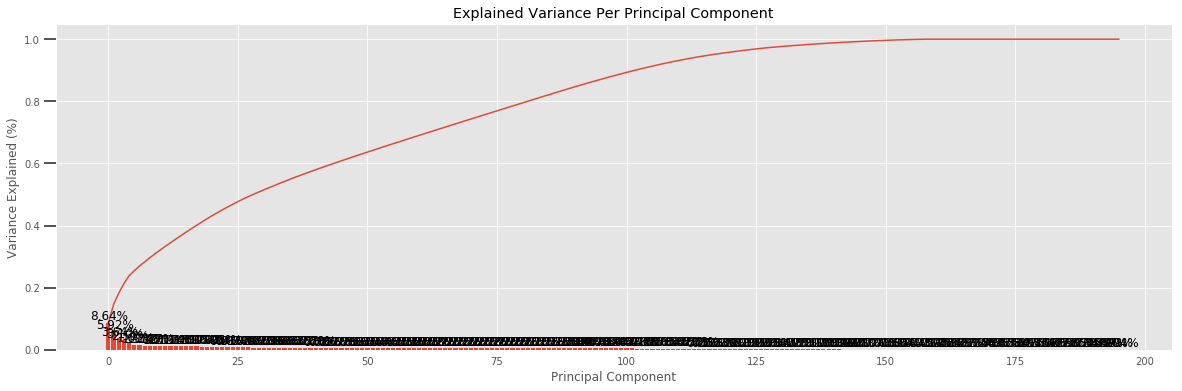

In [46]:
# Investigate the variance accounted for by each principal component.
pca = PCA()
X_pca = pca.fit_transform(X)
scree_plot(pca)


processing:  40
processing:  41
processing:  42
processing:  43
processing:  44
processing:  45
processing:  46
              Explained Variance  ALTERSKATEGORIE_GROB  ANREDE_KZ  \
Dimension 1               0.0865               -0.0893     0.0079   
Dimension 2               0.0592                0.2339     0.0397   
Dimension 3               0.0365                0.0205    -0.3329   
Dimension 4               0.0311               -0.0072     0.1095   
Dimension 5               0.0252                0.0536    -0.0611   
Dimension 6               0.0161                0.0060     0.0118   
Dimension 7               0.0152                0.0112     0.0086   
Dimension 8               0.0135                0.0052    -0.0171   
Dimension 9               0.0132               -0.0367     0.0364   
Dimension 10              0.0128                0.0123    -0.0083   
Dimension 11              0.0122               -0.0743     0.0382   
Dimension 12              0.0119                0.0123    -0

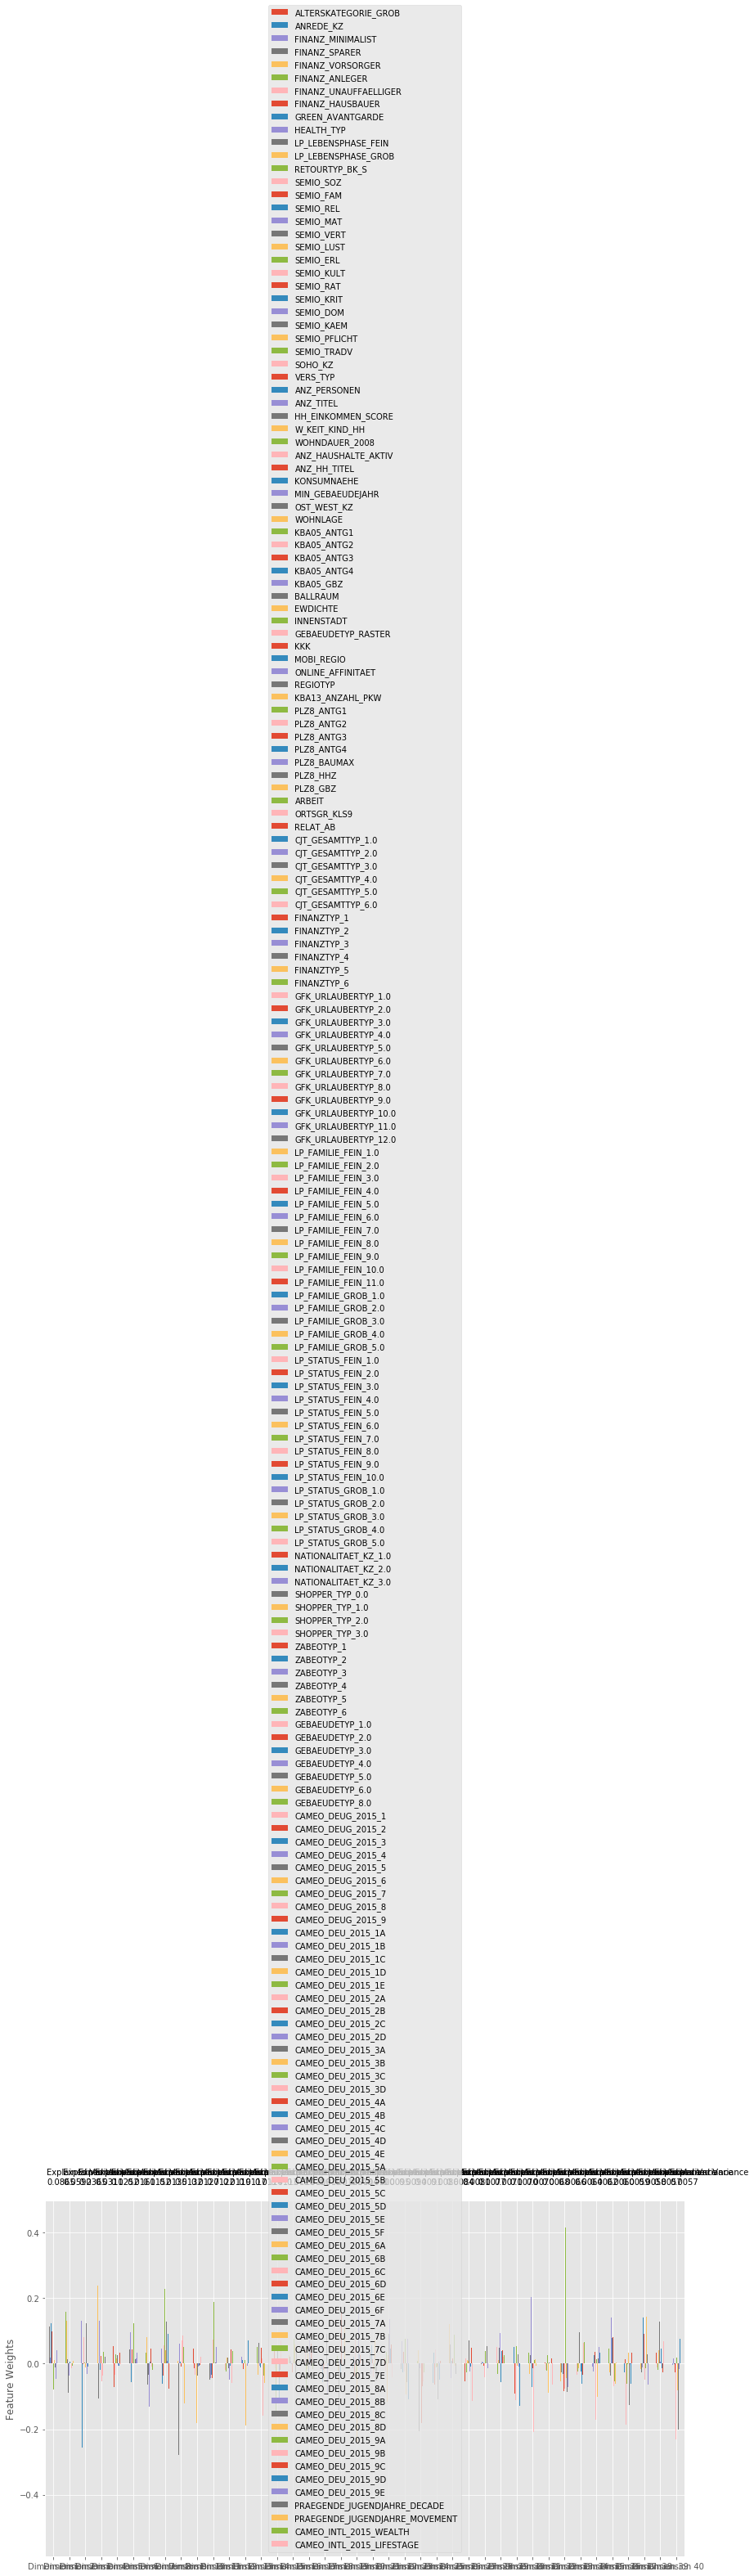

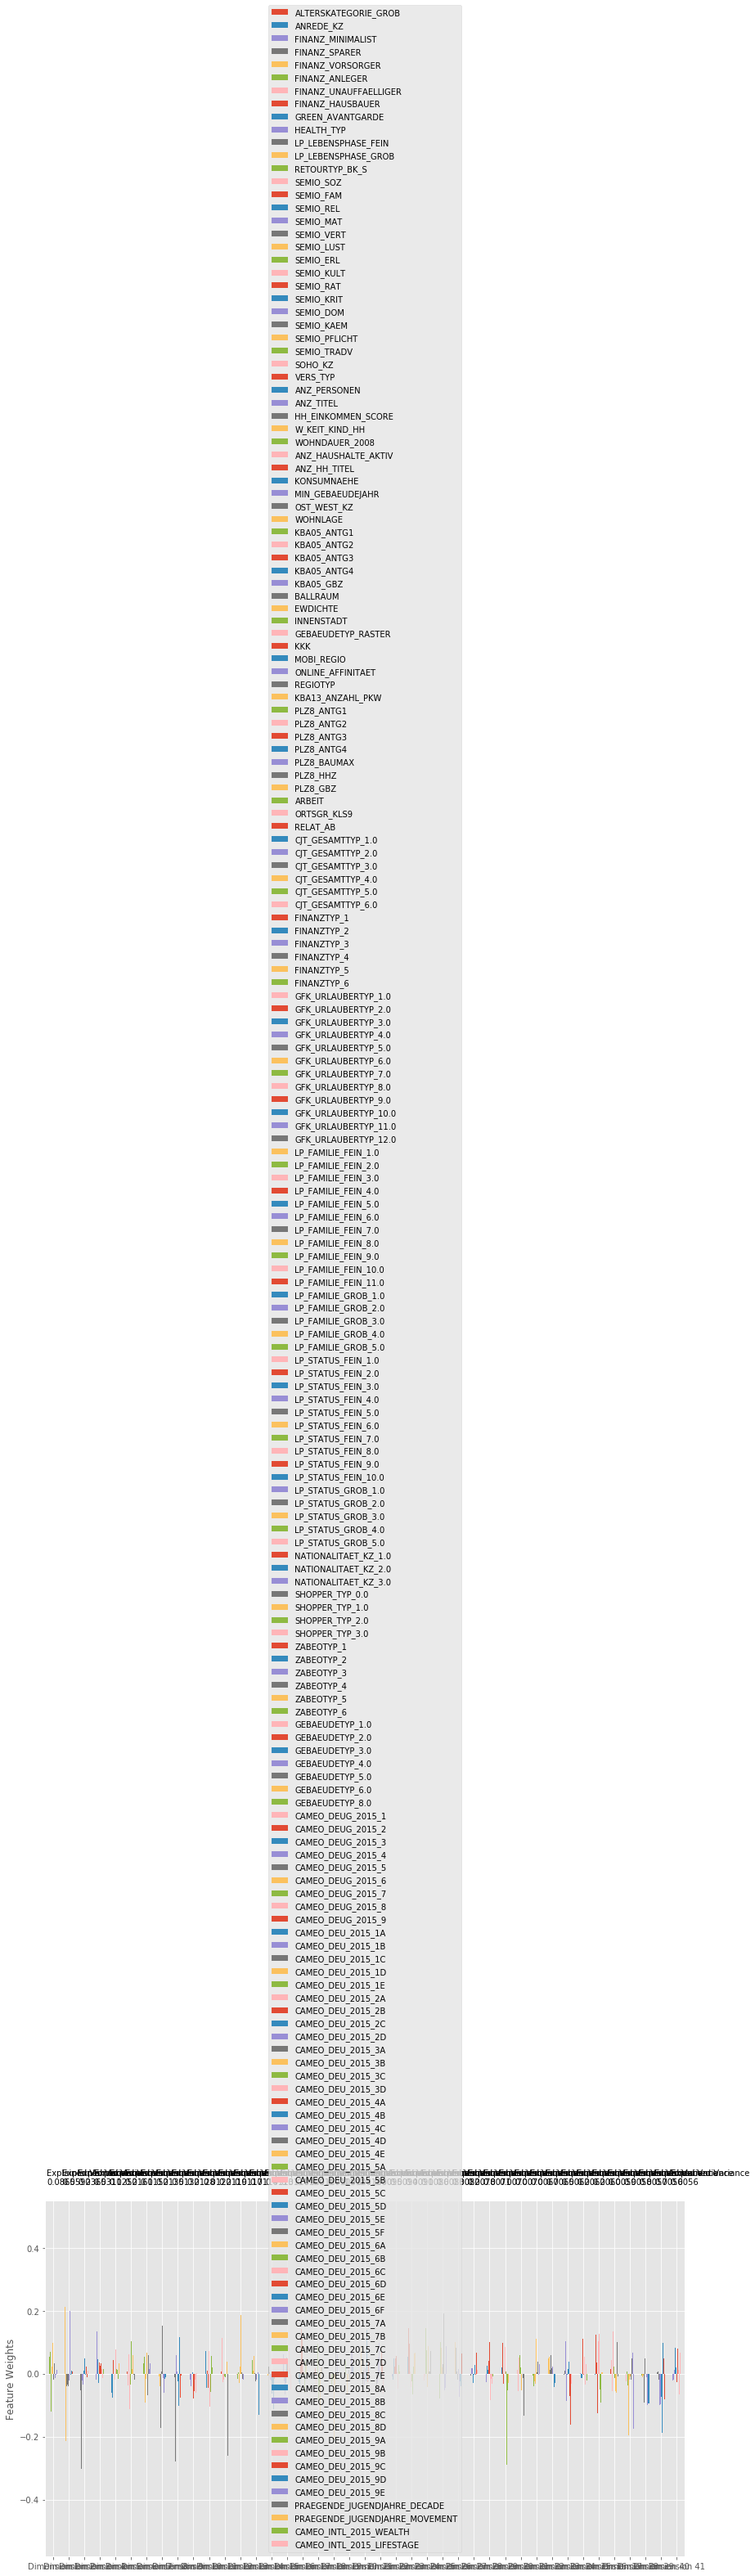

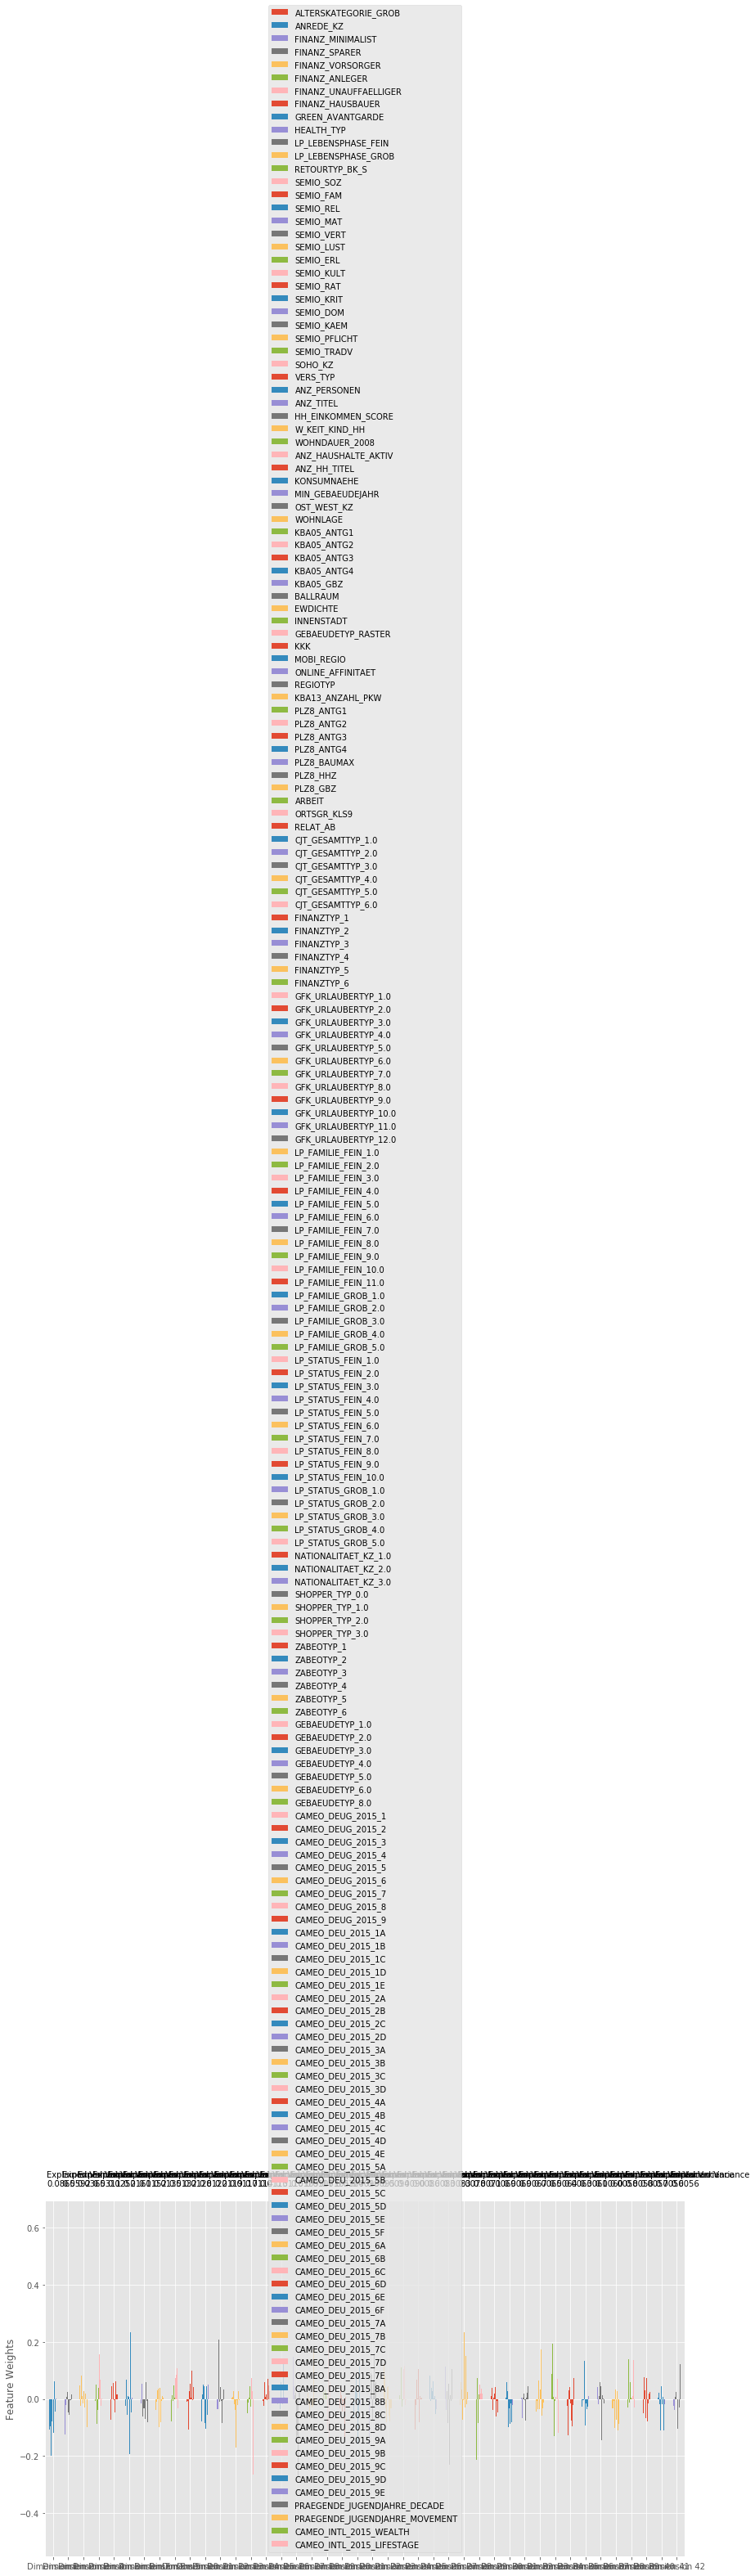

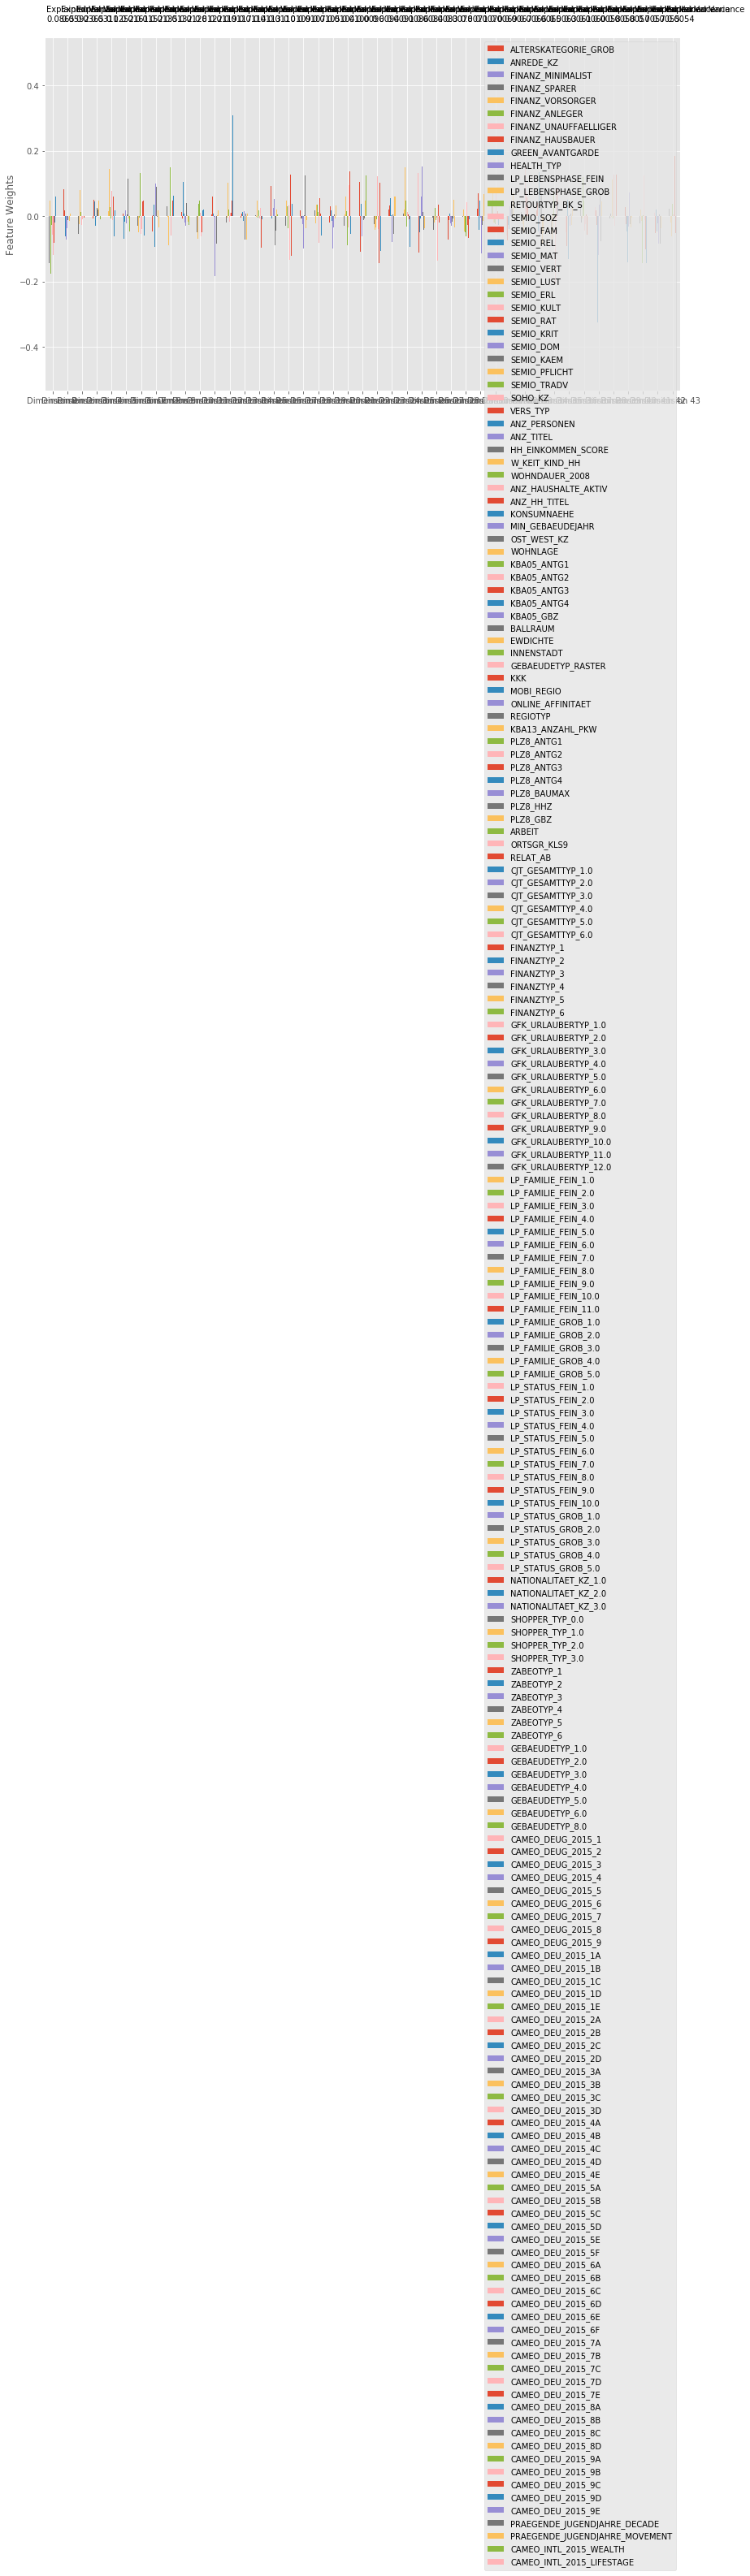

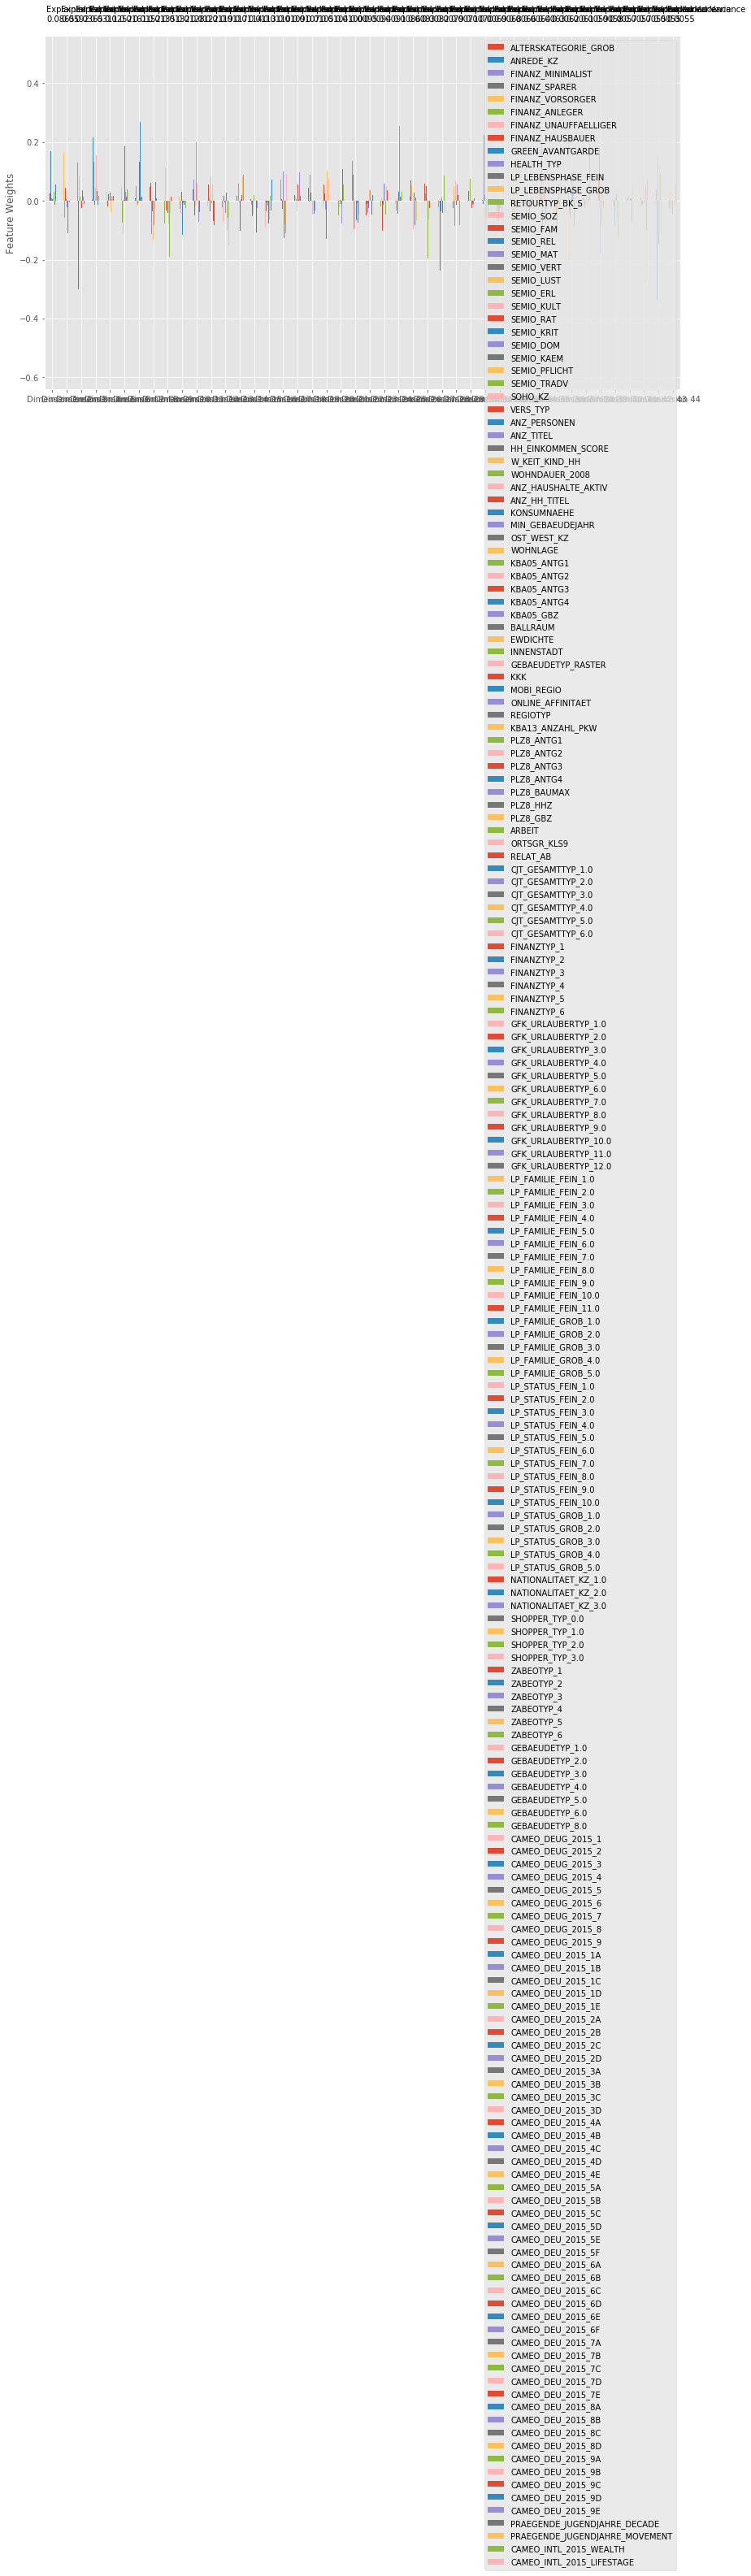

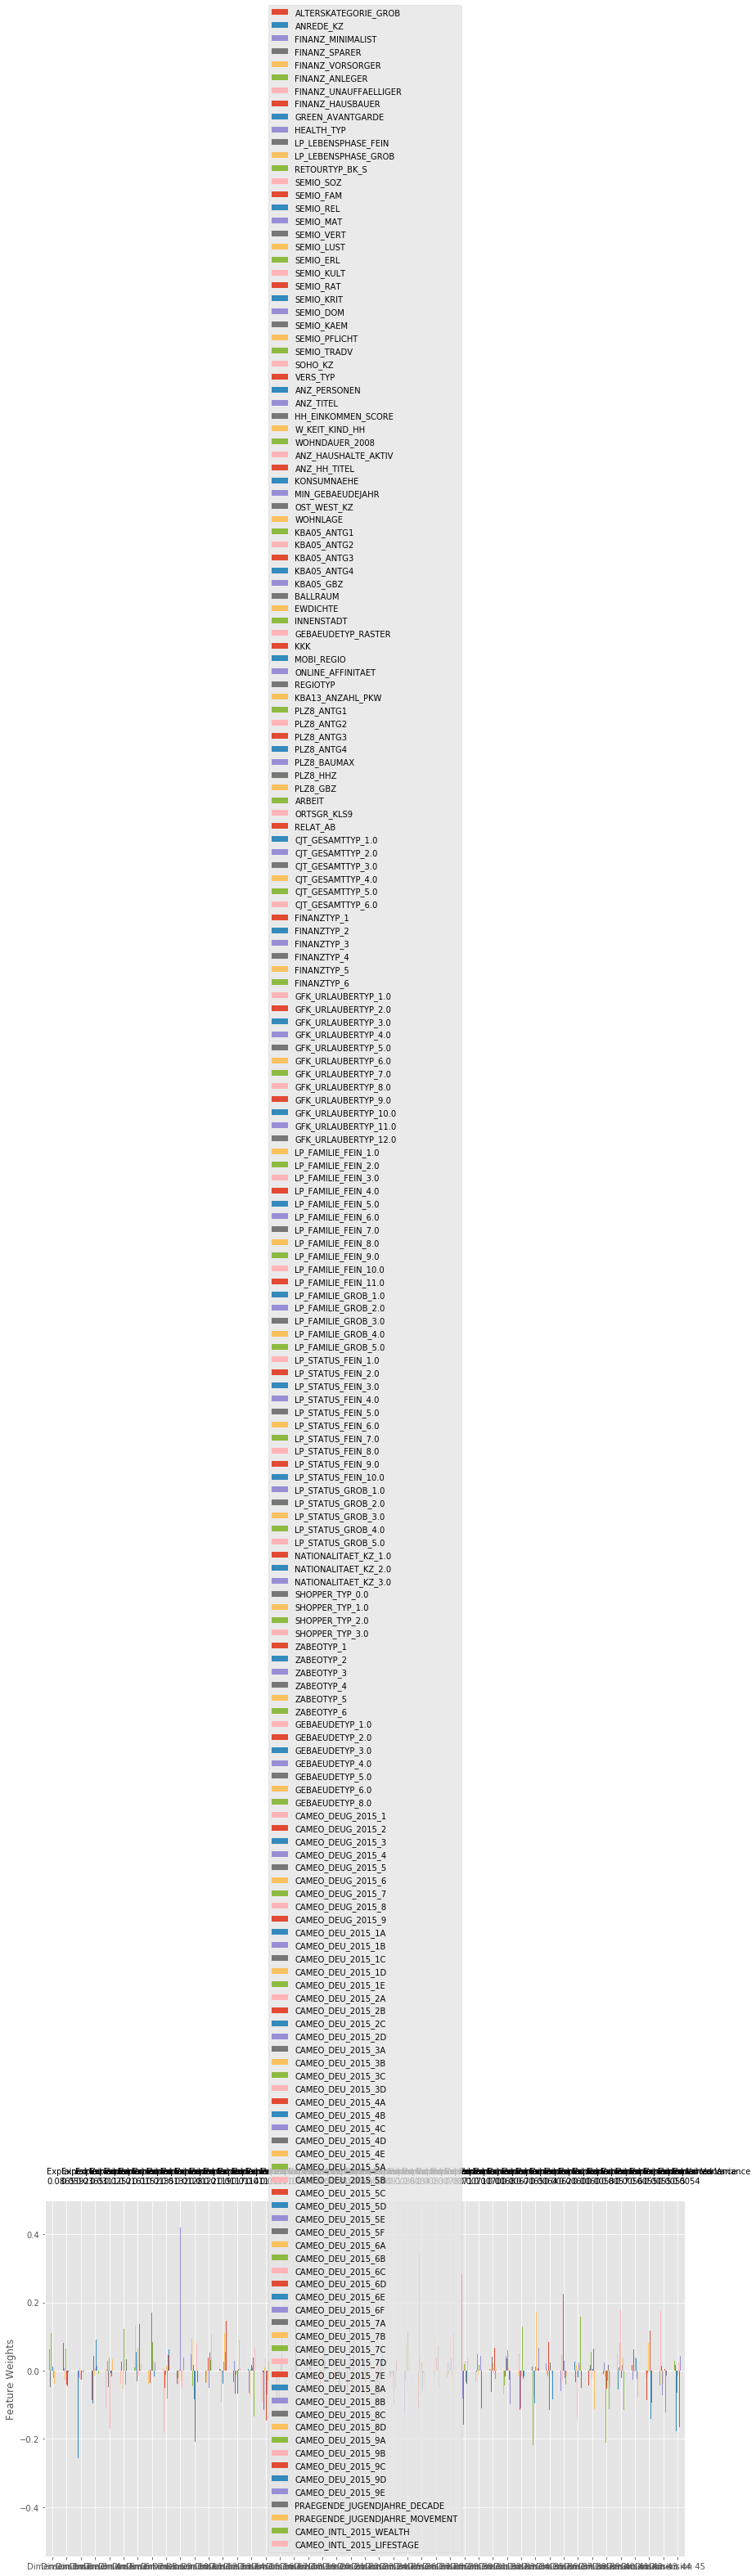

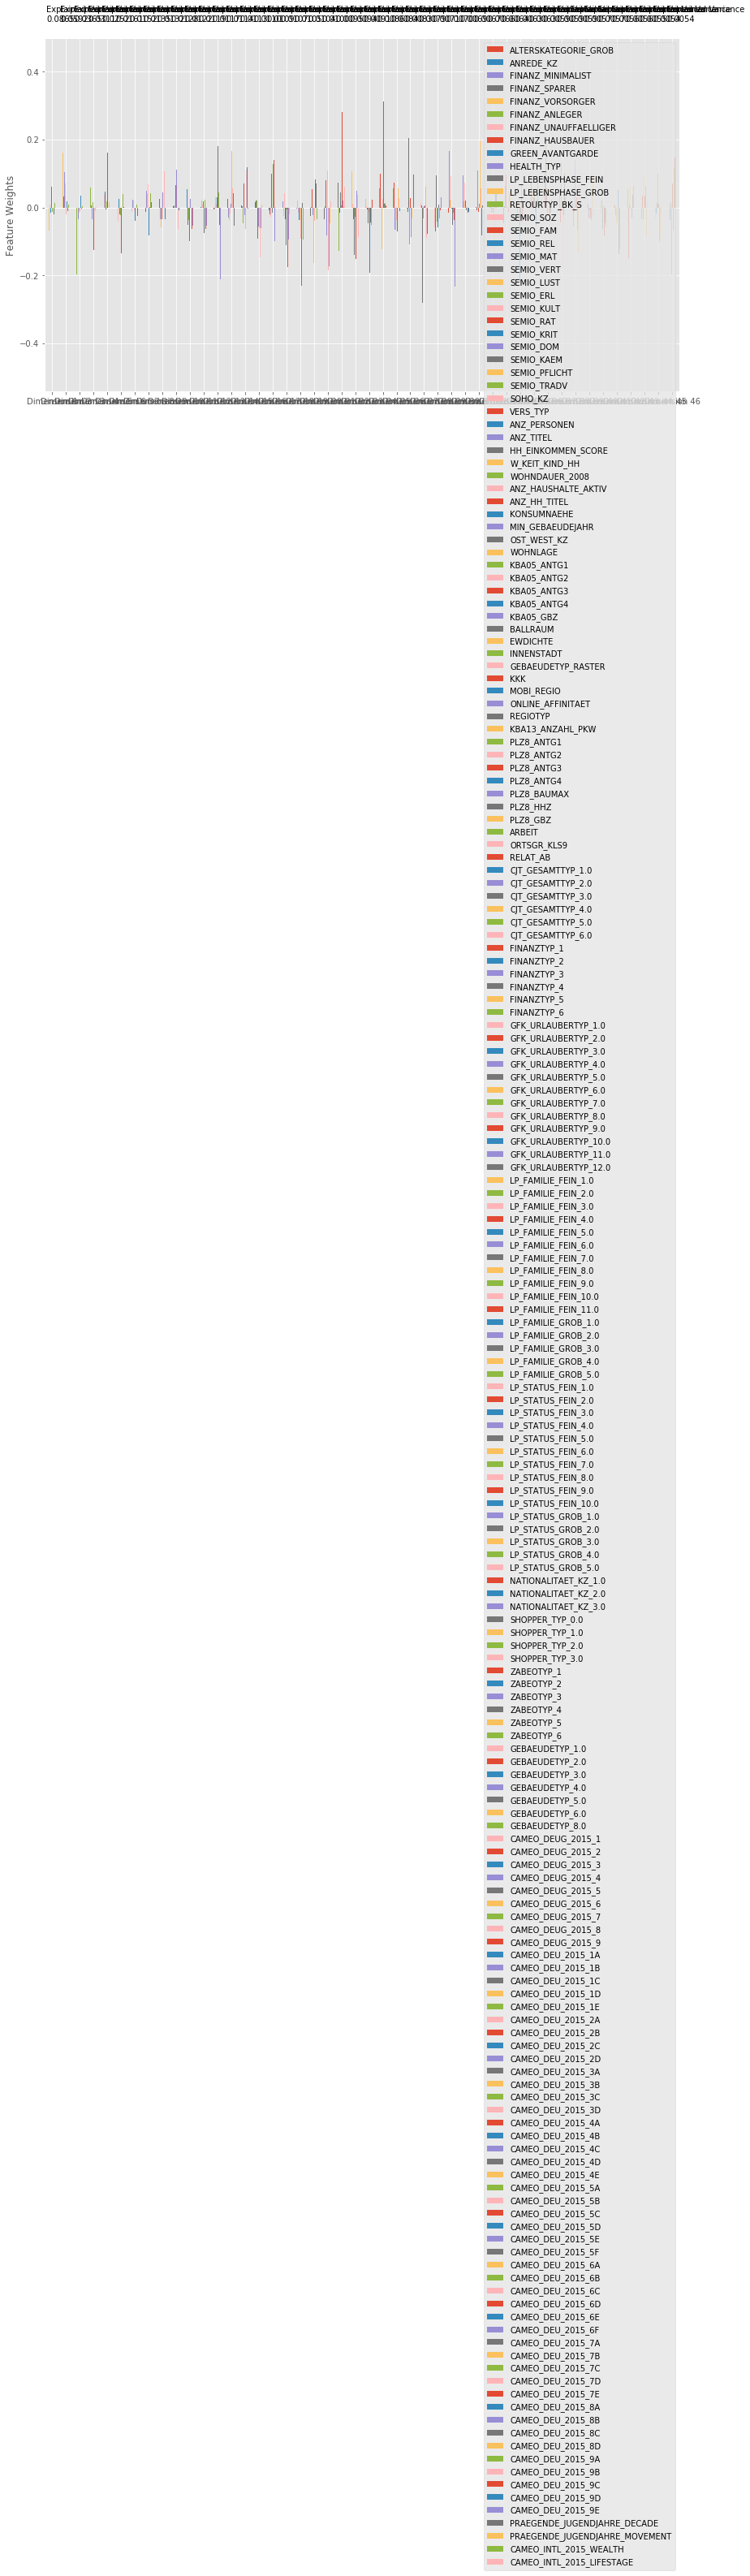

In [47]:
# azdias.shape[1]
for comp in range(40, azdias.shape[1]):
    print('processing: ', comp)
    pca, X_pca = do_pca(comp, azdias)
    comp_check = get_best_n_comp(azdias, pca)
    if comp_check['Explained Variance'].sum() > 0.60:
        break
        

print(comp_check)
num_comps = comp_check.shape[0]
print('# of components to get more than 60% of variance explained: ', num_comps)

In [45]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(46, azdias)

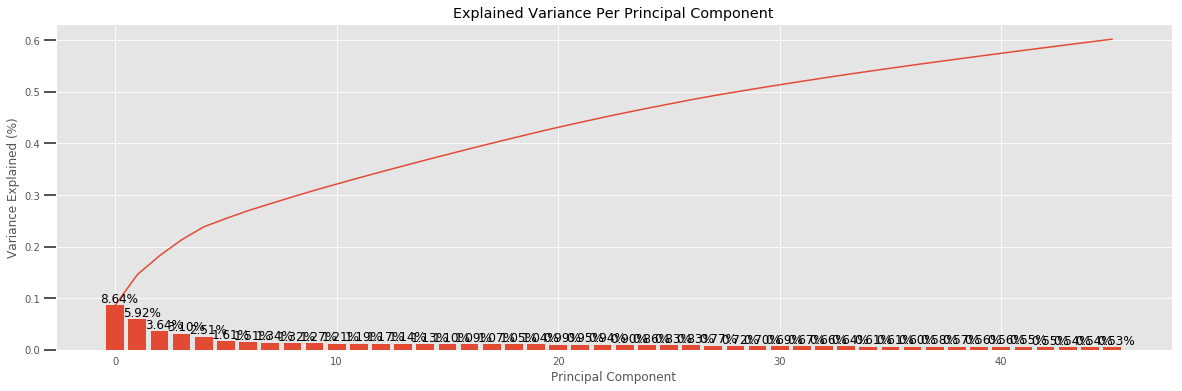

In [46]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

(reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I decided to keep 46 principal components since it's where it reaches 60% of total variability explained.

Initially, I looked into where the line graph starts to level off to determine the number of principal components to retain based on the suggestions in this [link](https://www.quora.com/What-is-the-best-way-to-choose-the-number-of-components-in-PCA-during-dimensionality-reduction).

I conducted an analysis first with all principal components (194) and found out that the cumulative proportion of variance explained seemd to level off around 6, 40 and 125 components.
Also, for the first component, 8.64% of total variability is explained by this component. And 5.92% for the second component. 

As having 6 wouldn't produce high enough total variability explained, I decided to find a point where the explained variability reaches around 80% with less number of principal components required.

So, I tried with 83 components next.
But this took so much time to run PCA so I chose 46 components to retain which has around 60% variability explained.

One last thing to note is that adding more PC doesn't seem to increase the % of variance explained after the 6th component.



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. **The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list**. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [47]:
def pca_results(full_dataset, pca, n_component):
    '''
    Return the heads and tails (10 each) of the PCA results and visualise them
    '''
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys()).iloc[n_component - 1]
    components.sort_values(ascending=False, inplace=True)
    components = pd.concat([components.head(10), components.tail(10)])
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights")


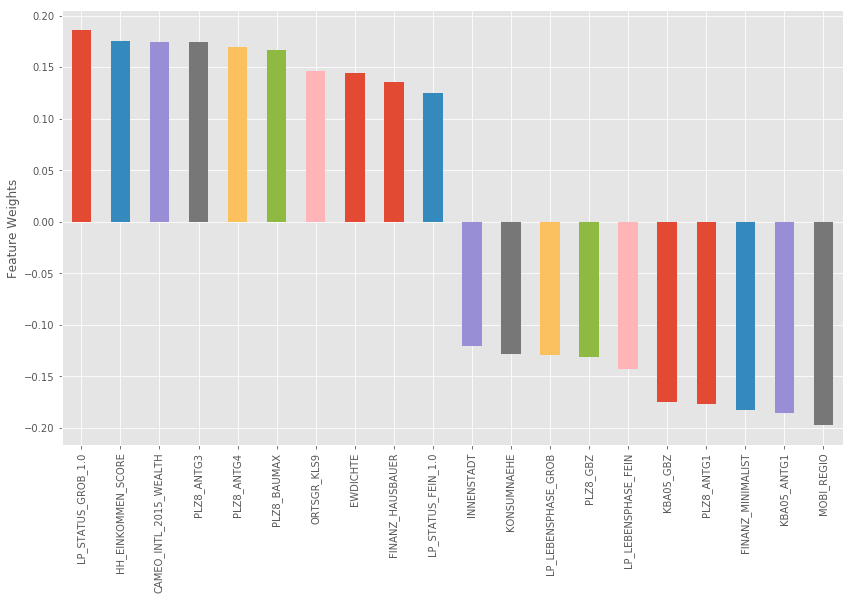

In [48]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca_results(azdias, pca, 1)


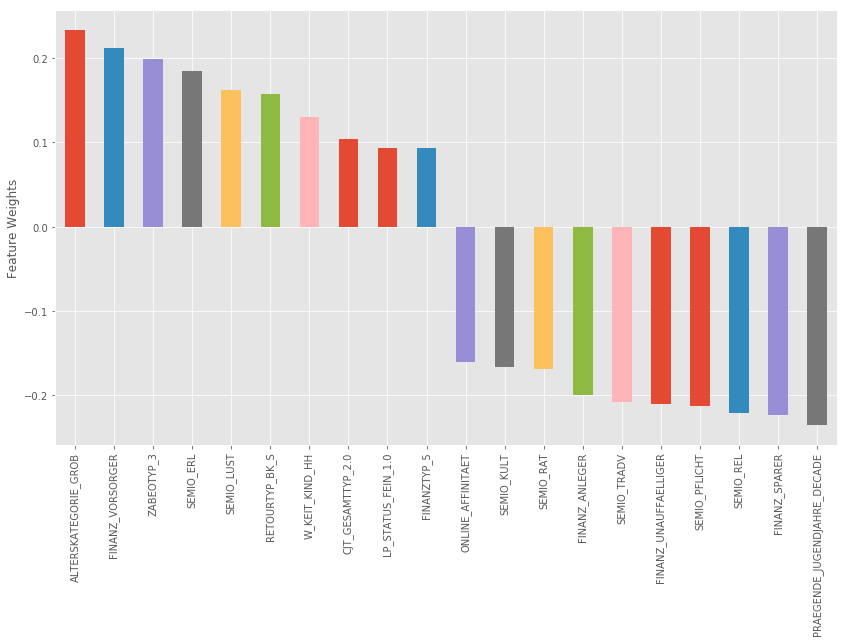

In [49]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias, pca, 2)


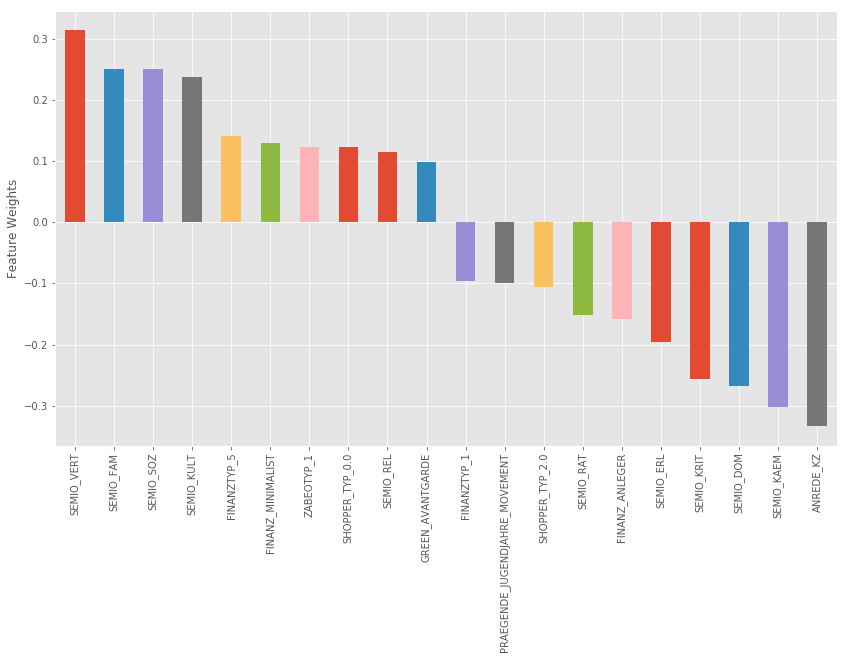

In [50]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias, pca, 3)


### Discussion 2.3: Interpret Principal Components

(reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

### First principal component

The top 5 positive values in this component are related to social staus and financial affluence:
- LP_STATUS_GROB_1.0 (Social status)
- HH_EINKOMMEN_SCORE (Estimated household net income)
- CAMEO_INTL_2015_WEALTH (German Cameo: Wealth typology mapped to international code)
- PLZ8_ANTG3 (Number of cars in 6-10 family houses in the PLZ8 region)
- PLZ8_ANTG4 (Number of cars in 10+ family houses in the PLZ8 region)

The negative values that are correlated to the above positive values are related to movement patterns in regions, family size, financial interest, and # of buildings:

- MOBI_REGIO (Movement patterns)
- KBA05_ANTG1 (Number of 1-2 family houses in the microcell)
- FINANZ_MINIMALIST (Financial typology of the people with low financial interest)
- PLZ8_ANTG1 (Number of cars in 1-2 family houses in the PLZ8 region)
- KBA05_GBZ (Number of buildings in the microcell)

Based on this result, I think it can be said that wealth positively impacts the principal component while having low financial interest, movement patterns and number of buildings in the microcell. Number of cars and family size can have either positive or negative impact depending on its number and size respectively.

### Second principal component

The top 5 positive values in this component are related to estimated age, financial preparedness, consumption tendency, and personality:
- ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
- FINANZ_VORSORGER (financial typology of the be prepared)
- ZABEOTYP_3 (Energy consumption typology of the fair supplied)
- SEMIO_ERL (Personality typology of the event-oriented)
- SEMIO_LUST (Personality typology of the sensual-minded)

The negative values that are correlated to the above positive values are related to age, money spending habit, and personality:

- PRAEGENDE_JUGENDJAHRE_DECADE (Dominating movement of person's youth by age decade)
- FINANZ_SPARER (Financial typology of money-saver)
- SEMIO_REL (Personality typology of the religious-minded)
- SEMIO_PFLICHT (Personality typology of the dutiful-minded)
- FINANZ_UNAUFFAELLIGER (Financial typology of the inconsipicuous)

Based on this result, it seems that there's a correlation between age and one's personality that may influece one's spending habit.

### Third principal component

The top 5 positive values in this component are related to personality and the financial type of investors:

- SEMIO_VERT (Personality typology of the dreamful)
- SEMIO_FAM (Personality typology of the family-minded)
- SEMIO_SOZ (Personality typology of the socially-minded)
- SEMIO_KULT (Personality typology of the cultural-minded)
- INANZTYP (Descriptive financial type for investors)

The negative values that are correlated to the above positive values are related to gender and personality:
- ANREDE_KZ (Gender)
- SEMIO_KAEM (Personality typology of the combative attitude)
- SEMIO_DOM (Personality typology of the dominant-minded)
- SEMIO_KRIT (Personality typology of the critical-minded)
- SEMIO_ERL (Personality typology of the event-oriented)

Based on this result, it seems that socially-minded and cultural-minded people tend to be an investor type. And age has some impact on personalities.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. **You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30**.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
cluster_counts = np.arange(1, 26)
score_list = []


# Over a number of different cluster counts...
for k in cluster_counts:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_pca)
    
    # compute the average within-cluster distances.
    score_list.append(np.abs(kmeans.score(X_pca)))


Text(0,0.5,'Score')

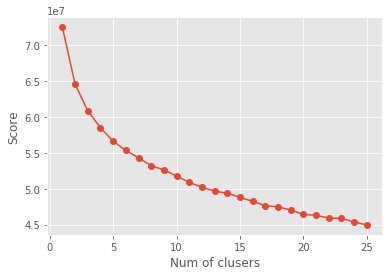

In [62]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_counts, score_list, marker='o')
plt.xlabel('Num of clusers')
plt.ylabel('Score')


In [63]:
cluster_counts = np.arange(1, 16)
score_list = []


# Over a number of different cluster counts...
for k in cluster_counts:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_pca)
    
    # compute the average within-cluster distances.
    score_list.append(np.abs(kmeans.score(X_pca)))


Text(0,0.5,'Score')

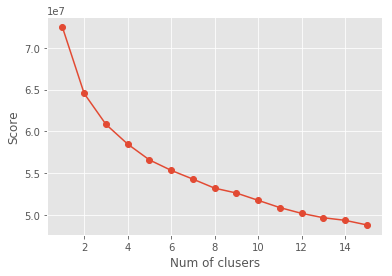

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_counts, score_list, marker='o')
plt.xlabel('Num of clusers')
plt.ylabel('Score')


In [51]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
def kmeans_clustering(pca, n_cluster):
    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(pca)
    labels = kmeans.predict(pca)
    centers = kmeans.cluster_centers_
    return kmeans, labels, centers
    
kmeans, labels, centers = kmeans_clustering(X_pca, 15)

### Discussion 3.1: Apply Clustering to General Population

(reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

To find a elbow point, an indicator for the optimal k, I plotted 2 the score v.s. num of clusters graph, one plotting 25 clusters and one with 15.

While neither of the graphs showed a clear elbow point, I chose 15 for the number of clusters as the rate of decrease in the score seemd to plateau around that point.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. **Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data.** In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [52]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head(10)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   
5         1                     3          1            4.0   
6         2                     4          1            2.0   
7         1                     4          1            2.0   
8         2                     4          2            1.0   
9         1                     3          1            3.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   
5                  5              1                 5               1   
6                  5              1                 5               1   
7                  5              1                 5               1   
8                  2              2                 5               1   
9                  5              2                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   
3                      1                 2    ...            3.0         2.0   
4                      5                 2    ...            2.0         4.0   
5                      2                 3    ...            2.0         3.0   
6                      1                 2    ...            3.0         2.0   
7                      2                 2    ...            3.0         3.0   
8                      1                 5    ...            1.0         4.0   
9                      3                 1    ...            3.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   
5         2.0         1.0          1.0       5.0       5.0     3.0   
6         1.0         0.0          1.0       5.0       5.0     2.0   
7         1.0         1.0          1.0       3.0       3.0     3.0   
8         2.0         1.0          5.0       5.0       4.0     3.0   
9         1.0         0.0          1.0       5.0       5.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  
5          7.0       5.0  
6          3.0       2.0  
7          4.0       3.0  
8          8.0       3.0  
9          6.0       4.0  

[10 rows x 85 columns]

In [53]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cleaned_customer = clean_data(customers)
cleaned_customer.head(10)

before removing NaNs 2443597
after 161830


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0          1                  5              1   
1                   4.0          2                  5              1   
2                   4.0          1                  5              1   
3                   3.0          1                  3              1   
4                   3.0          1                  5              1   
5                   4.0          1                  5              1   
6                   4.0          1                  5              1   
7                   4.0          2                  2              2   
8                   3.0          1                  5              2   
9                   4.0          1                  5              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 5               1                      2                 2   
1                 5               1                      4                 4   
2                 5               2                      1                 2   
3                 4               4                      5                 2   
4                 5               1                      2                 3   
5                 5               1                      1                 2   
6                 5               1                      2                 2   
7                 5               1                      1                 5   
8                 4               1                      3                 1   
9                 5               1                      3                 2   

   GREEN_AVANTGARDE  HEALTH_TYP            ...              CAMEO_DEU_2015_8D  \
0                 1         1.0            ...                              0   
1                 1         2.0            ...                              0   
2                 0         2.0            ...                              0   
3                 0         3.0            ...                              0   
4                 1         3.0            ...                              0   
5                 1         2.0            ...                              0   
6                 1         1.0            ...                              0   
7                 0         2.0            ...                              0   
8                 1         3.0            ...                              0   
9                 1         1.0            ...                              0   

   CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   
5                  0                  0                  0                  0   
6                  0                  0                  0                  0   
7                  0                  0                  0                  0   
8                  0                  0                  0                  0   
9                  0                  0                  0                  0   

   CAMEO_DEU_2015_9E  PRAEGENDE_JUGENDJAHRE_DECADE  \
0                  0                           1.0   
1                  0                           1.0   
2                  0                           0.0   
3                  0                           3.0   
4                  0                           1.0   
5                  0                           1.0   
6                  0                           1.0   
7                  1                           0.0   
8                  0                           3.0   
9    

In [54]:
azdias.shape

(623209, 196)

In [55]:
cleaned_customer.shape # 1 column is missing...!

(141725, 195)

In [56]:
# Investigate which column is missing
list(set(azdias.columns) - set(cleaned_customer)) # 'GEBAEUDETYP_5.0' is missing

# add the missing column to the customer dataset to match the number of columns
cleaned_customer['GEBAEUDETYP_5.0'] = 0
cleaned_customer['GEBAEUDETYP_5.0']


# adding constant values to pandas dataframe => https://stackoverflow.com/questions/24039023/add-column-with-constant-value-to-pandas-dataframe

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
141695    0
141696    0
141697    0
141698    0
141699    0
141700    0
141701    0
141702    0
141703    0
141704    0
141705    0
141706    0
141707    0
141708    0
141709    0
141710    0
141711    0
141712    0
141713    0
141714    0
141715    0
141716    0
141717    0
141718    0
141719    0
141720    0
141721    0
141722    0
141723    0
141724    0
Name: GEBAEUDETYP_5.0, Length: 141725, dtype: int64

In [57]:
cleaned_customer.shape # num of columns matches!

(141725, 196)

In [58]:
cleaned_customer.isnull().sum().sum()

126772

In [59]:
c_copy = cleaned_customer.copy()
c_copy.isnull().sum(axis=1).sum()
c_copy.dropna(inplace=True)
c_copy.reset_index(inplace=True, drop=True)

In [60]:
print('% of # of rows with NaNs {}%'.format(round(cleaned_customer.shape[0] / 891221 *100), 2))
print('% of # of rows with NaNs removed {}%'.format(round(c_copy.shape[0] / 891221 *100), 2))

% of # of rows with NaNs 16%
% of # of rows with NaNs removed 13%


In [61]:
# drop NaNs from the customer dataset
cleaned_customer.dropna(inplace=True)
cleaned_customer.reset_index(inplace=True, drop=True)
cleaned_customer.isnull().sum().sum()

0

In [62]:
cleaned_customer.shape

(115643, 196)

In [63]:
# scale, PCA, clustering steps, predict
X_customer = scaler.fit_transform(cleaned_customer)
pca_customer = pca.transform(X_customer)
pred_customer = kmeans.predict(pca_customer)
pred_customer

array([ 4,  1,  3, ...,  4,  7, 10], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. **If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company.** On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

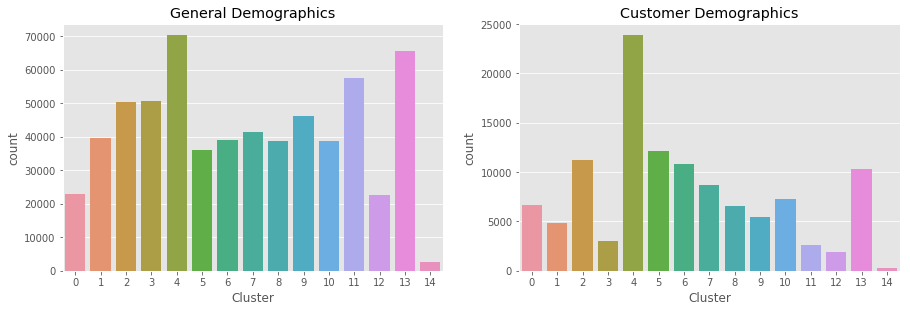

In [64]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def compare_gen_cus(general, customer):
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax1.set_title('General Demographics')
    ax2.set_title('Customer Demographics')
    ax1.set_xlabel('Cluster')
    ax2.set_xlabel('Cluster')
    
    sns.countplot(general, ax=ax1)
    sns.countplot(customer, ax=ax2)

compare_gen_cus(labels, pred_customer)

In [111]:
pca_financial = ['HH_EINKOMMEN_SCORE', 'CAMEO_INTL_2015_WEALTH', 'FINANZ_VORSORGER', 'FINANZ_SPARER',
                       'FINANZ_MINIMALIST', 'FINANZ_UNAUFFAELLIGER']
pca_personality = ['SEMIO_ERL', 'SEMIO_LUST', 'SEMIO_REL', 'SEMIO_PFLICHT']

pca_others = ['MOBI_REGIO', 'ALTERSKATEGORIE_GROB', 'KBA05_ANTG1', 'KBA05_GBZ', 'PLZ8_ANTG1',
              'PLZ8_ANTG3', 'PRAEGENDE_JUGENDJAHRE_DECADE','ANREDE_KZ']


# Positive Values from the first principal components
# LP_STATUS_GROB (Social status)
# HH_EINKOMMEN_SCORE (Estimated household net income)
# CAMEO_INTL_2015_WEALTH (German Cameo: Wealth typology mapped to international code)
# PLZ8_ANTG3 (Number of cars in 6-10 family houses in the PLZ8 region)

# Positive Values from the second principal components
# ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
# FINANZ_VORSORGER (financial typology of the be prepared)
# SEMIO_ERL (Personality typology of the event-oriented)
# SEMIO_LUST (Personality typology of the sensual-minded)

# Negative Values from the first principal components
# MOBI_REGIO (Movement patterns)
# KBA05_ANTG1 (Number of 1-2 family houses in the microcell)
# FINANZ_MINIMALIST (Financial typology of the people with low financial interest)
# PLZ8_ANTG1 (Number of  cars in 1-2 family houses in the PLZ8 region)
# KBA05_GBZ (Number of buildings in the microcell)

# Negative Values from the second principal components
# PRAEGENDE_JUGENDJAHRE_DECADE (Dominating movement of person's youth by age decade)
# FINANZ_SPARER (Financial typology of money-saver)
# SEMIO_REL (Personality typology of the religious-minded)
# SEMIO_PFLICHT (Personality typology of the dutiful-minded)
# FINANZ_UNAUFFAELLIGER (Financial typology of the inconsipicuous)

In [213]:
count_gen = pd.Series(labels).value_counts(normalize=True)
count_gen = pd.DataFrame({'Ratio of labels in General Population': count_gen})
count_gen

Ratio of labels in General Population
4                                0.112789
13                               0.105191
11                               0.092237
3                                0.081509
2                                0.080804
9                                0.074339
7                                0.066658
1                                0.063739
6                                0.062660
10                               0.062408
8                                0.062002
5                                0.057894
0                                0.036885
12                               0.036550
14                               0.004336

In [215]:
count_cus = pd.Series(pred_customer).value_counts(normalize=True)
count_cus = pd.DataFrame({'Ratio of labels in Customer Population': count_cus})
diff = count_cus['Ratio of labels in Customer Population'] - count_gen['Ratio of labels in General Population']
diff.sort_values(inplace=True)

diff

11   -0.069910
3    -0.055489
9    -0.027618
1    -0.021817
12   -0.019748
13   -0.016349
8    -0.004912
14   -0.001465
10    0.000363
7     0.008201
2     0.015968
0     0.020827
6     0.031328
5     0.047188
4     0.093432
dtype: float64

In [216]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
over_rep = scaler.inverse_transform(pca.inverse_transform(X_pca[labels == 4]))
over_rep = pd.DataFrame(np.round(over_rep), columns=azdias.columns)

# https://stackoverflow.com/questions/49885007/how-to-use-scikit-learn-inverse-transform-with-new-values


In [217]:
def compare_clusters(k, column):
    fig= plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(4, 2, 4)
    sns.countplot(k[column], ax=ax)


### Overrepresented Cluster Financial Demographics

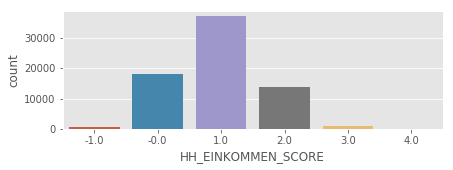

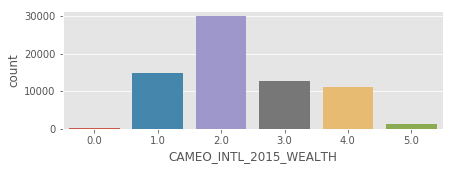

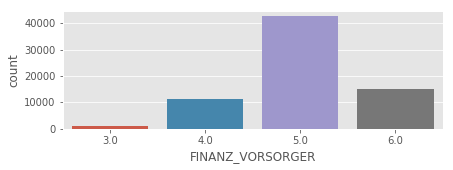

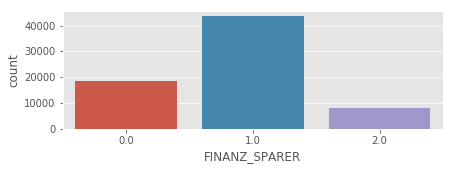

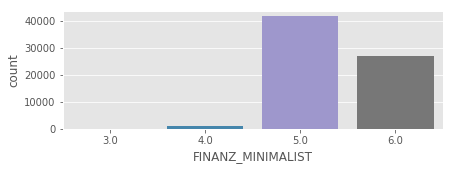

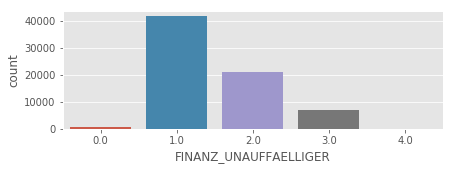

In [218]:
for val in pca_financial:
    compare_clusters(over_rep, val)

### Personality Demographics

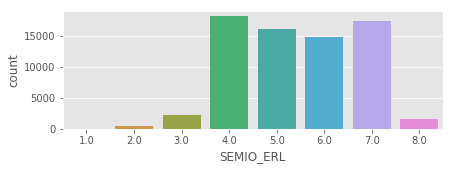

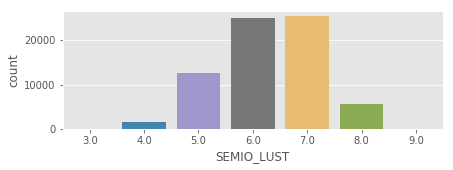

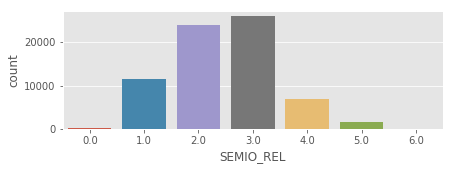

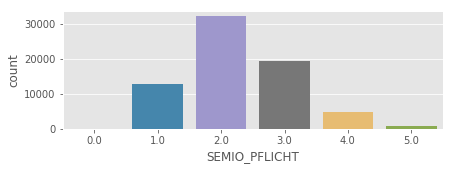

In [219]:
for val in pca_personality:
    compare_clusters(over_rep, val)

### Other Demographics

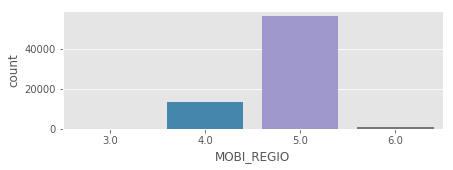

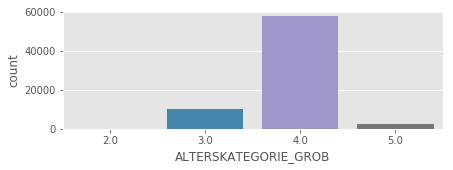

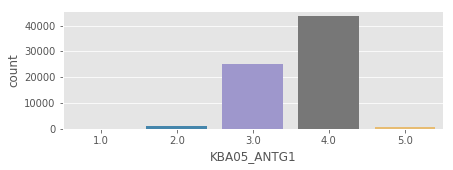

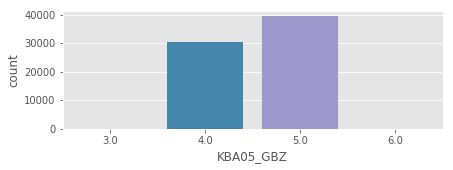

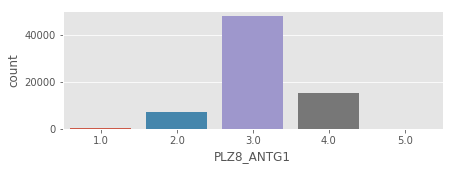

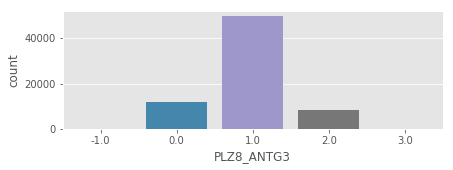

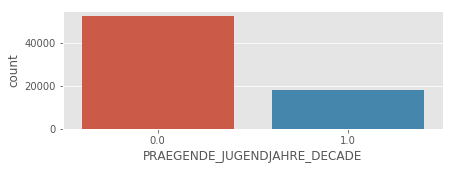

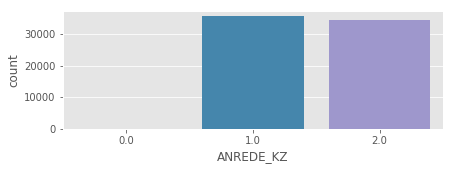

In [220]:
for val in pca_others:
    compare_clusters(over_rep, val)

In [221]:
##What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?):
under_rep = scaler.inverse_transform(pca.inverse_transform(X_pca[labels == 11]))
under_rep = pd.DataFrame(np.round(under_rep), columns=cleaned_customer.columns)

### Under-represented Cluster Financial Demographics

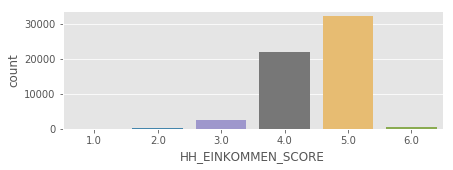

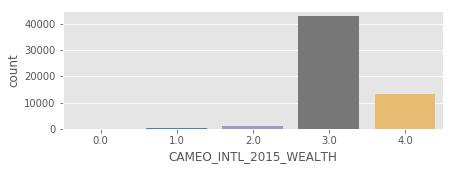

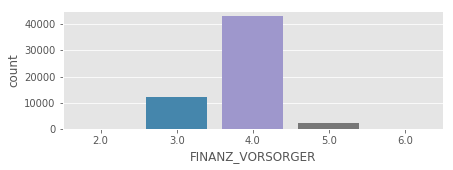

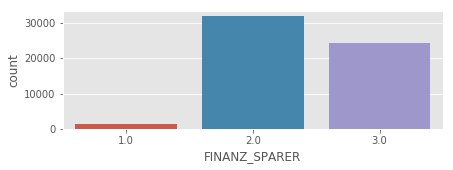

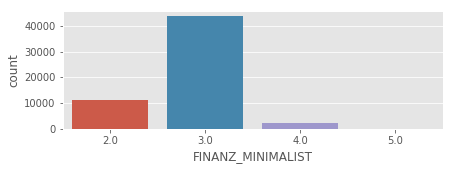

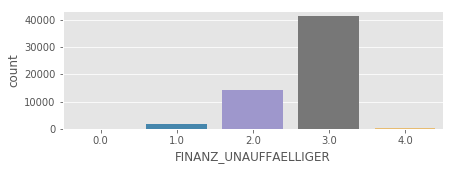

In [225]:
for val in pca_financial:
    compare_clusters(under_rep, val)
    

### Personality Demographics

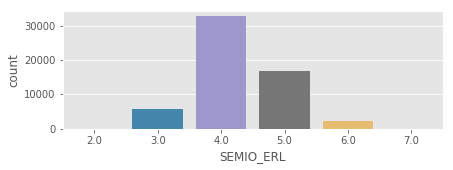

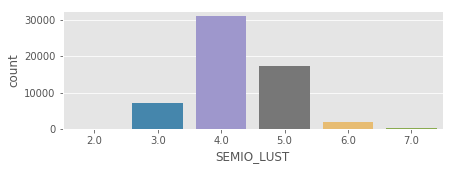

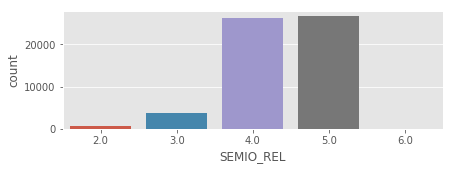

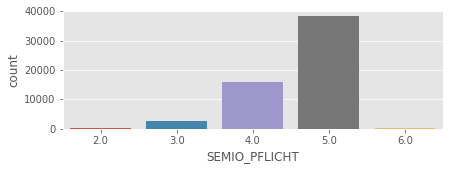

In [224]:
for val in pca_personality:
    compare_clusters(under_rep, val)

### Other Demographics

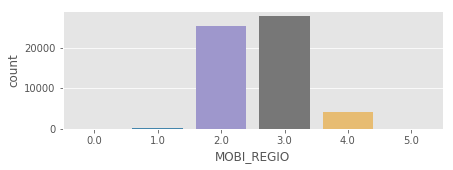

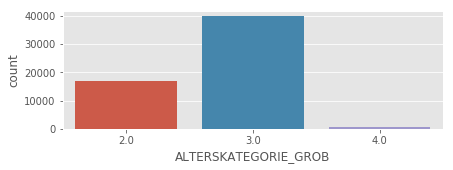

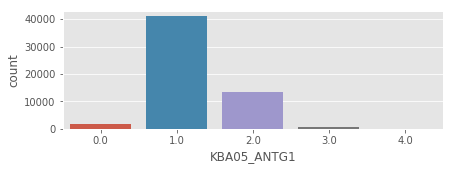

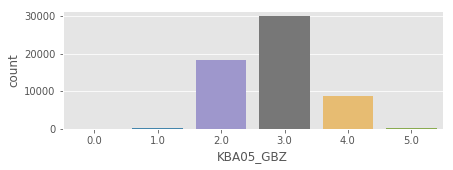

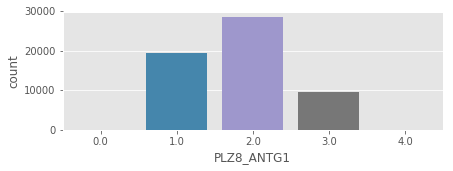

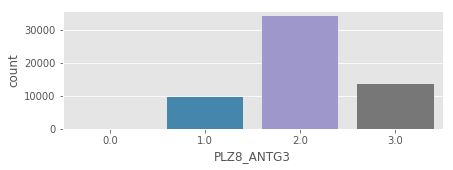

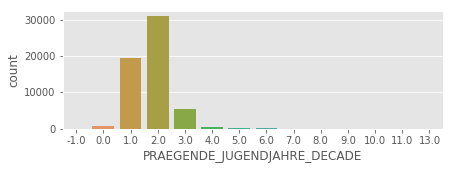

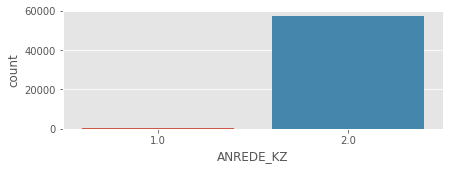

In [223]:
for val in pca_others:
    compare_clusters(under_rep, val)

### Discussion 3.3: Compare Customer Data to Demographics Data

(reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

From the clustring analysis, I found out that **cluster 4 is overrepresented** in the customer data (60.78% of the customer population and 11.28% of the general population) compared to the general population while **cluster 11 is underrepresented** (2.34% of the customer population and 0.43% of the general population).

I will elaborate on this finding below.

**Cluster 4: Financial Demographics**
- have highest estimated household net income but from comfortable households in terms of wealth.
- tend to be very low in their financial preparedness and have very low financial interest but very high in money-saving behaviours

**Cluster 4: Personality Demographics**
- have average to low affinity to event-orientedness, low affinity to sensual-mindedness.
- tend to be highly religious(high affinity) and dutiful (very high affinity)


**Cluster 4: Other Demographics**
- movement patterns tend to be very low.
- age older than 60 years old
- live in an area where it has very high share of 1-2 family homes.
- have high car share of 1-2 family homes in PLZ8 region.
- live in an area with high number of buildings (>=23)
- the gender ratio is close to equal

**Cluster 11: Financial Demographics**
- tend to be lower in their estimated household net income
- tend to be low in their financial preparedness and have average financial interest. High in money-saving behaviours


**Cluster 11: Personality Demographics**
- have average affinity to event-orientedness and sensual-mindedness.
- tend to be average or low in religiousness
- less dutiful (low affinity)


**Cluster 11: Other Demographics**
- movement patterns tend to be from middle high.
- age between 46 and 60 years old
- live in an area where it has lower share of 1-2 family homes.
- have average car share of 1-2 family homes in PLZ8 region.
- live in an area with small to medium number of buildings (5-16)
- predominantly females

So in conclusion, the population that are relatively popular with the mail-order company are those who over 60s from wealthy households comprised on 1-2 families, live in crowded area(probably cities considering the high number of buildings in microcell), and highly religous and dutiful while unpopular ones are females between 46-60 years old from relatively low income household who live in probably suburbs and have low affinity to religiousness and dutifullness.

This is the end of my analysis. I only looked into columns that are seemed to have high positive or negative weights in the principal components but I'm not so sure this was the right move.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.